### Feature Engineering


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mldl_hw3.preprocessing import DataLoader
from mldl_hw3.consts import Brand
from mldl_hw3.experiment import Experiment, ExperimentConfig

from typing import Optional

from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from category_encoders import TargetEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
df_train, df_test = DataLoader("../dataset").load()

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4428 entries, G4XLU0 to J2RCU8
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Name               4428 non-null   category
 1   Location           4428 non-null   category
 2   Year               4428 non-null   Int64   
 3   Kilometers_Driven  4428 non-null   Int64   
 4   Fuel_Type          4428 non-null   category
 5   Transmission       4428 non-null   category
 6   Owner_Type         4428 non-null   category
 7   Mileage            4428 non-null   float64 
 8   Engine             4428 non-null   Int64   
 9   Power              4336 non-null   float64 
 10  Colour             4428 non-null   category
 11  Seats              4428 non-null   Int64   
 12  Doors              4428 non-null   Int64   
 13  New_Price          601 non-null    float64 
 14  Price              4428 non-null   float64 
dtypes: Int64(5), category(6), float64(4)
memory usage: 40

In [5]:
X_train = df_train.copy()
y_train = X_train.pop("Price")
X_test = df_test.drop(columns=["Price"])

### Baseline


In [6]:
class CategoricalEncoder(TransformerMixin, BaseEstimator):
    def fit(
        self, X: pd.DataFrame, y: Optional[pd.Series] = None
    ) -> "CategoricalEncoder":
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        for feature in X.select_dtypes(["category"]):
            X[feature] = X[feature].cat.codes

        return X

In [7]:
def build_baseline_pipeline(**model_params) -> Pipeline:
    return Pipeline(
        [
            ("encoder", CategoricalEncoder()),
            ("model", XGBRegressor(**model_params)),
        ]
    )

In [8]:
baseline_exp = Experiment(
    ExperimentConfig(name="baseline", pipeline=build_baseline_pipeline())
)

baseline_exp_result = baseline_exp.run(X_train, y_train, X_test)

[Experiment: baseline]
Cross-validating (5-folds)...
CV score: 0.1606 ± 0.0163
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/baseline.csv
Experiment complete



#### `Brand` extraction from `Name`


Form the analysis on `preprocessing.ipynb`, we found that `Name` feature has too many cateogires.
The car's name usually consists of brand and model. From common knowledge, we know that the car's brand has significant impact on forming its price. Based on this domain knowledge and to reduce category, we extract `Brand` from `Name`.


In [9]:
class BrandModelExtractor(TransformerMixin, BaseEstimator):
    def __init__(
        self,
        name_col: str = "Name",
        brand_col: str = "Brand",
        model_col: str = "Model",
        brand_enum=Brand,
    ):
        self.name_col = name_col
        self.brand_col = brand_col
        self.model_col = model_col
        self.brand_enum = brand_enum

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series]) -> "BrandModelExtractor":
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        names = X[self.name_col].str.title()
        brands = pd.Series([None] * len(names), index=names.index, dtype=object)
        models = pd.Series([None] * len(names), index=names.index, dtype=object)

        for brand in Brand:
            condition = names.str.startswith(brand.value, na=False) & brands.isna()

            if condition.any():
                brands.loc[condition] = brand.name
                matched_names = names.loc[condition]
                residuals = matched_names.str[len(brand.value) :].str.strip()
                models.loc[condition] = residuals.where(residuals != "", None)

        brands = brands.rename("Brand").astype("category")
        models = models.rename("Model").astype("category")

        X[self.brand_col] = brands
        X[self.model_col] = models

        return X

In [10]:
X_train = df_train.copy()
y_train = X_train.pop("Price")

df_train_bm = pd.DataFrame(BrandModelExtractor().fit_transform(X_train, y_train))
df_train_bm

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Colour,Seats,Doors,New_Price,Brand,Model
ID,,,,,,,,,,,,,,,,
G4XLU0,Tata Indigo,Coimbatore,2013,59138,Diesel,Manual,First,17.00,1405,70.00,Others,5,4,NaN,Tata,Indigo
CRSHOS,Toyota Corolla,Kochi,2013,81504,Diesel,Manual,First,21.43,1364,87.20,Others,5,4,NaN,Toyota,Corolla
FUJ4X1,Ford Ikon,Hyderabad,2007,92000,Petrol,Manual,First,13.80,1299,70.00,Others,5,4,NaN,Ford,Ikon
QMVK6E,Hyundai i20,Kolkata,2012,33249,Diesel,Manual,First,21.27,1396,88.76,Black/Silver,5,4,NaN,Hyundai,I20
4SWHFC,Honda City,Bangalore,2011,65000,Petrol,Manual,First,17.00,1497,118.00,White,5,4,NaN,Honda,City
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TR7SLB,Mahindra XUV500,Kochi,2016,51884,Diesel,Manual,First,16.00,2179,140.00,White,7,5,NaN,Mahindra,Xuv500
QB41QE,Honda Jazz,Kolkata,2016,27210,Diesel,Manual,First,27.30,1498,98.60,Others,5,4,NaN,Honda,Jazz
ODG8N7,Land Rover Range,Pune,2015,52000,Diesel,Automatic,First,12.70,2179,187.70,White,5,4,NaN,Land_Rover,Range


Note that `Brand` and `Model` has an hierarchical relationship.


In [11]:
display(
    df_train_bm[["Brand", "Model"]].groupby(["Brand", "Model"], observed=True).count()
)


Empty DataFrame
Columns: []
Index: [(Audi, A3), (Audi, A4), (Audi, A6), (Audi, A7), (Audi, A8), (Audi, Q3), (Audi, Q5), (Audi, Q7), (Audi, Rs5), (Audi, Tt), (BMW, 1), (BMW, 3), (BMW, 5), (BMW, 6), (BMW, 7), (BMW, X1), (BMW, X3), (BMW, X5), (BMW, X6), (BMW, Z4), (Bentley, Continental), (Chevrolet, Aveo), (Chevrolet, Beat), (Chevrolet, Captiva), (Chevrolet, Cruze), (Chevrolet, Enjoy), (Chevrolet, Optra), (Chevrolet, Sail), (Chevrolet, Spark), (Datsun, Go), (Datsun, Redi), (Datsun, Redi-Go), (Fiat, Avventura), (Fiat, Grande), (Fiat, Linea), (Fiat, Petra), (Fiat, Punto), (Fiat, Siena), (Force, One), (Ford, Aspire), (Ford, Ecosport), (Ford, Endeavour), (Ford, Fiesta), (Ford, Figo), (Ford, Freestyle), (Ford, Fusion), (Ford, Ikon), (Honda, Accord), (Honda, Amaze), (Honda, Br-V), (Honda, Brio), (Honda, Brv), (Honda, City), (Honda, Civic), (Honda, Cr-V), (Honda, Jazz), (Honda, Mobilio), (Honda, Wr-V), (Honda, Wrv), (Hyundai, Accent), (Hyundai, Creta), (Hyundai, Elantra), (Hyundai, Elite), (Hyundai, Eon), (Hyundai, Getz), (Hyundai, Grand), (Hyundai, I10), (Hyundai, I20), (Hyundai, Santa), (Hyundai, Santro), (Hyundai, Sonata), (Hyundai, Tucson), (Hyundai, Verna), (Hyundai, Xcent), (Isuzu, D-Max), (Isuzu, Mux), (Jaguar, F), (Jaguar, Xe), (Jaguar, Xf), (Jaguar, Xj), (Jeep, Compass), (Lamborghini, Gallardo), (Land_Rover, Discovery), (Land_Rover, Freelander), (Land_Rover, Range), (Mahindra, Bolero), (Mahindra, Jeep), (Mahindra, Kuv), (Mahindra, Logan), (Mahindra, Nuvosport), (Mahindra, Quanto), (Mahindra, Renault), (Mahindra, Scorpio), (Mahindra, Ssangyong), (Mahindra, Thar), (Mahindra, Tuv), (Mahindra, Verito), (Mahindra, Xuv300), (Mahindra, Xuv500), (Mahindra, Xylo), ...]

[204 rows x 0 columns]

In [12]:
df_train_bm.Brand.unique()

['Tata', 'Toyota', 'Ford', 'Hyundai', 'Honda', ..., 'Smart', 'Isuzu', 'Volvo', 'Bentley', 'Lamborghini']
Length: 29
Categories (29, object): ['Audi', 'BMW', 'Bentley', 'Chevrolet', ..., 'Tata', 'Toyota', 'Volkswagen', 'Volvo']

In [13]:
df_train_bm.Brand.value_counts()

Brand
Maruti           884
Hyundai          817
Honda            462
Toyota           309
Mercedes_Benz    239
Volkswagen       225
Ford             217
Mahindra         199
BMW              191
Audi             177
Tata             140
Skoda            117
Renault          117
Chevrolet         82
Nissan            64
Land_Rover        43
Jaguar            28
Fiat              23
Mini              21
Mitsubishi        20
Porsche           14
Volvo             14
Jeep              11
Datsun             7
Isuzu              3
Lamborghini        1
Force              1
Smart              1
Bentley            1
Name: count, dtype: int64

In [14]:
df_train_bm.Model.unique()

['Indigo', 'Corolla', 'Ikon', 'I20', 'City', ..., 'Cls-Class', 'Gallardo', 'Wr-V', 'Outlander', 'Xc90']
Length: 201
Categories (201, object): ['1', '3', '5', '6', ..., 'Yeti', 'Z4', 'Zen', 'Zest']

In [15]:
with pd.option_context("display.max_rows", None):
    display(df_train_bm.Model.value_counts())

Model
Swift          253
City           206
I20            183
Verna          129
Grand          125
Innova         121
I10            120
Wagon          113
Alto           107
Polo           107
Xuv500          89
New             80
Amaze           80
Fortuner        77
Vento           76
3               75
Ecosport        72
Figo            71
Creta           69
Duster          65
E-Class         63
Ertiga          58
A4              55
Santro          53
Ciaz            51
Corolla         51
Etios           50
Ritz            48
5               47
Baleno          45
Brio            44
Jazz            44
Eon             44
Celerio         44
Scorpio         40
Xcent           39
A6              36
Vitara          35
Kwid            34
Superb          34
Indigo          29
Beat            29
Civic           27
Q7              27
Endeavour       27
Indica          27
Rapid           26
Q5              25
Fiesta          25
X1              24
Zen             24
Octavia         23
Micra 

`Model` feature has too high cardinality, and there are non-legligible amount of categories with very small sample. Since we already have `Brand`, we could just drop `Model`. Alternatively, we could try target encoding.


0. Baseline (only `Name`)


1. Categorical `Brand` and `Model` added


In [16]:
extract_brand_model_exp = Experiment(
    ExperimentConfig(
        name="extract-brand-model",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

extract_brand_model_exp.run(X_train, y_train, X_test, baseline_exp_result);

[Experiment: extract-brand-model]
Cross-validating (5-folds)...
CV score: 0.1905 ± 0.0190
         +0.0299  +0.0027 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/extract-brand-model.csv
Experiment complete



2. Drop `Model`


In [17]:
class FeatureDropper(TransformerMixin, BaseEstimator):
    def __init__(self, cols: list[str]):
        self.cols = cols

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series]) -> "FeatureDropper":
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return X.drop(columns=self.cols)

In [18]:
drop_model_exp = Experiment(
    ExperimentConfig(
        name="drop-model",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                ("drop_model", FeatureDropper(["Model"])),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

drop_model_exp.run(X_train, y_train, X_test, baseline_exp_result);

[Experiment: drop-model]
Cross-validating (5-folds)...
CV score: 0.1606 ± 0.0163
         +0.0000  +0.0000 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/drop-model.csv
Experiment complete



3. Drop `Name`


In [19]:
drop_name_exp = Experiment(
    ExperimentConfig(
        name="drop-name",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                ("drop_name", FeatureDropper(["Name"])),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

drop_name_exp.run(X_train, y_train, X_test, baseline_exp_result);

[Experiment: drop-name]
Cross-validating (5-folds)...
CV score: 0.2379 ± 0.0157
         +0.0772  -0.0006 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/drop-name.csv
Experiment complete



4. Target encoding `Model`. (Leave `Brand` categorical)


In [20]:
model_te_exp = Experiment(
    ExperimentConfig(
        name="model-te",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                ("target_encode", TargetEncoder(cols=["Model"])),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

model_te_exp.run(X_train, y_train, X_test, baseline_exp_result);

[Experiment: model-te]
Cross-validating (5-folds)...
CV score: 0.1523 ± 0.0107
         -0.0083  -0.0056 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/model-te.csv
Experiment complete



5. Target encoding `Brand` and `Model`.


In [21]:
brand_model_te_exp = Experiment(
    ExperimentConfig(
        name="brand-model-te",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                ("target_encode", TargetEncoder(cols=["Brand", "Model"])),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

brand_model_te_exp.run(X_train, y_train, X_test, baseline_exp_result);


[Experiment: brand-model-te]
Cross-validating (5-folds)...
CV score: 0.1496 ± 0.0170
         -0.0110  +0.0007 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/brand-model-te.csv
Experiment complete



6. Target encoding `Brand`, `Model`, and `Name`.


In [22]:
brand_model_name_te_exp = Experiment(
    ExperimentConfig(
        name="brand-model-name-te",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                (
                    "target_encode",
                    TargetEncoder(cols=["Brand", "Model", "Name"]),
                ),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

brand_model_name_te_exp.run(X_train, y_train, X_test, baseline_exp_result);

[Experiment: brand-model-name-te]
Cross-validating (5-folds)...
CV score: 0.1505 ± 0.0136
         -0.0101  -0.0027 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/brand-model-name-te.csv
Experiment complete



Target encoding `Brand`, `Model`, and `Name` yields the biggest gain.


Thinking deeper on the hierarchical relationship of `Brand` and `Model`, the difference of `Model` target encoded value and `Brand` target encoded value can tell how high class is the car in that brand. Test whether this helps.


In [23]:
class ModelPremiumEncoder(TransformerMixin, BaseEstimator):
    def __init__(
        self,
        brand_col: str = "Brand",
        model_col: str = "Model",
        premium_col: str = "Model_Premium",
    ):
        self.brand_col = brand_col
        self.model_col = model_col
        self.premium_col = premium_col

    def fit(
        self, X: pd.DataFrame, y: Optional[pd.Series] = None
    ) -> "ModelPremiumEncoder":
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        X[self.premium_col] = X[self.model_col] - X[self.brand_col]
        return X

In [24]:
X_train = df_train.copy()
y_train = X_train.pop("Price")
X_test = df_test.copy().drop(columns=["Price"])

brand_model_name_mp_te_exp = Experiment(
    ExperimentConfig(
        name="model-premium",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                (
                    "target_encode",
                    TargetEncoder(cols=["Brand", "Model", "Name"]),
                ),
                ("model_premium", ModelPremiumEncoder()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

brand_model_name_mp_te_exp.run(X_train, y_train, X_test, baseline_exp_result);


[Experiment: model-premium]
Cross-validating (5-folds)...
CV score: 0.1485 ± 0.0161
         -0.0121  -0.0002 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/model-premium.csv
Experiment complete



`Model_Premium` improved the performance slightly. However, the gain is marginal and standard deviation is worse than without it. I think this is not worth it and will stick with target encoded `Brand`, `Model`, and `Name`.


#### Location


In [25]:
df_train.Location.value_counts()

Location
Mumbai        586
Hyderabad     546
Coimbatore    478
Kochi         475
Pune          465
Delhi         420
Kolkata       384
Chennai       362
Jaipur        315
Bangalore     237
Ahmedabad     160
Name: count, dtype: int64

There is no location with significantly small datapoints.

Since location can influence car price due to regional demand, wealth, urban/rural, taxes, ... target encoding could provide a valuable signal of this regional effect.


1. Categorical `Location` (Same as baseline)


In [26]:
baseline_exp.run(X_train, y_train);

[Experiment: baseline]
Cross-validating (5-folds)...
CV score: 0.1606 ± 0.0163
Training on full training set...
Experiment complete



1. Target encoded `Location`


In [27]:
X_train = df_train.copy()
y_train = X_train.pop("Price")
X_test = df_test.copy().drop(columns=["Price"])

location_te_exp = Experiment(
    ExperimentConfig(
        name="location target encoding",
        pipeline=Pipeline(
            [
                (
                    "target_encode",
                    TargetEncoder(cols=["Location"]),
                ),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

location_te_exp.run(X_train, y_train, X_test, baseline_exp_result);

[Experiment: location target encoding]
Cross-validating (5-folds)...
CV score: 0.1559 ± 0.0162
         -0.0047  -0.0001 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/location target encoding.csv
Experiment complete



It does help to target encode `Location`.


Combining with the `Name` feature engineering.


In [28]:
name_location_best_exp = Experiment(
    ExperimentConfig(
        name="name, location best feature engineering",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                (
                    "target_encode",
                    TargetEncoder(cols=["Brand", "Model", "Name", "Location"]),
                ),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

name_location_best_exp.run(X_train, y_train, X_test, baseline_exp_result);

[Experiment: name, location best feature engineering]
Cross-validating (5-folds)...
CV score: 0.1480 ± 0.0155
         -0.0127  -0.0008 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/name, location best feature engineering.csv
Experiment complete



Combined with engineered `Name`, it further increased the performance.

- brand-model-name-te: 0.1505 ± 0.0136
- brand-model-name-location-te: 0.1480 ± 0.0155


#### Year


In [29]:
df_train.Year.value_counts()

Year
2014    571
2016    564
2015    558
2013    484
2017    443
2012    411
2011    342
2010    247
2018    216
2009    146
2008    123
2007     93
2019     75
2006     55
2005     44
2004     21
2002     12
2003     11
2001      5
2000      3
1999      2
1998      2
Name: count, dtype: Int64

As explored in `preprocessing.ipynb`, calculating the `Age` might be more relevant in terms of price. Assuming that current year is 2020, I should try trasnforming `Year` to `Age`.


In [30]:
class YearToAgeTransformer(TransformerMixin, BaseEstimator):
    def __init__(
        self, year_col: str = "Year", age_col: str = "Age", current_year: int = 2020
    ):
        self.year_col = year_col
        self.age_col = age_col
        self.current_year = current_year

    def fit(
        self, X: pd.DataFrame, y: Optional[pd.Series] = None
    ) -> "YearToAgeTransformer":
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X[self.age_col] = self.current_year - X[self.year_col]
        X.drop(columns=[self.year_col], inplace=True)
        return X


0. `Year` (Same as baseline)


1. `Year` transformed to `Age`


In [31]:
year_to_age_transform_exp = Experiment(
    ExperimentConfig(
        name="year-to-age-transform",
        pipeline=Pipeline(
            [
                ("transform", YearToAgeTransformer()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

year_to_age_transform_exp.run(X_train, y_train, X_test, baseline_exp_result);

[Experiment: year-to-age-transform]
Cross-validating (5-folds)...
CV score: 0.1602 ± 0.0154
         -0.0004  -0.0009 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/year-to-age-transform.csv
Experiment complete



This transformation does not neccessarily add more information but makes it more interpretable and nice to work with other features.


In [32]:
name_location_year_exp = Experiment(
    ExperimentConfig(
        name="name-location-year-engineered",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                (
                    "target_encode",
                    TargetEncoder(cols=["Brand", "Model", "Name", "Location"]),
                ),
                ("transform", YearToAgeTransformer()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

name_location_year_exp.run(X_train, y_train, X_test, baseline_exp_result);

[Experiment: name-location-year-engineered]
Cross-validating (5-folds)...
CV score: 0.1479 ± 0.0159
         -0.0127  -0.0004 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/name-location-year-engineered.csv
Experiment complete



Together with the `Name` and `Location` engineered, transforming `Year` to `Age` did not help at all. It might be due to `Name` -> `Brand`, `Model`, `Name` being the dominant feature. However, I will keep this transformation since it makes the feature more interpretable while not hurting the performance. It could make this feature nicer to work with when analyzing interactions.


#### Kilometers Driven


In [33]:
df_train.Kilometers_Driven

ID
G4XLU0    59138
CRSHOS    81504
FUJ4X1    92000
QMVK6E    33249
4SWHFC    65000
          ...  
TR7SLB    51884
QB41QE    27210
ODG8N7    52000
EV2ZBX    56000
J2RCU8    52000
Name: Kilometers_Driven, Length: 4428, dtype: Int64

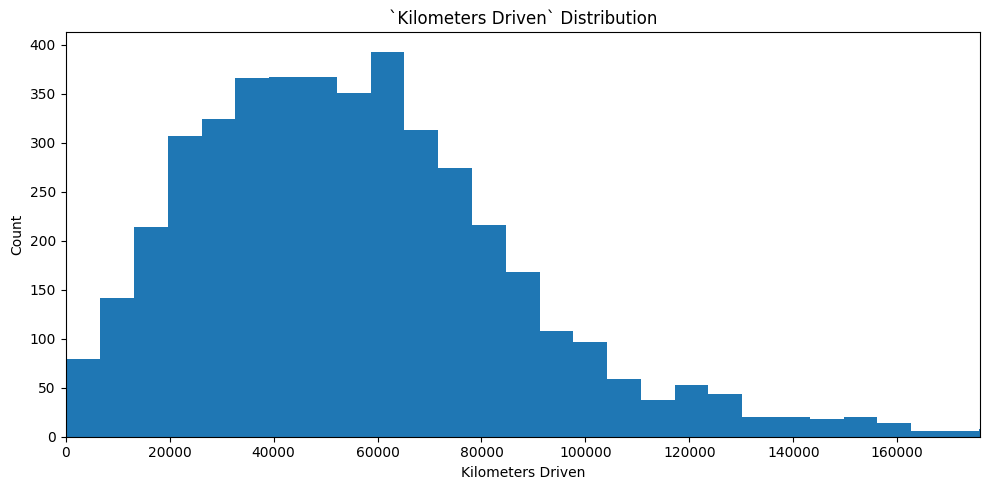

In [34]:
plt.figure(figsize=(10, 5))
plt.hist(df_train.Kilometers_Driven, bins=1000)
limit = np.percentile(df_train.Kilometers_Driven, 99)
plt.xlim(0, limit)
plt.xlabel("Kilometers Driven")
plt.ylabel("Count")
plt.title("`Kilometers Driven` Distribution")

plt.tight_layout()
plt.show()


This looks like a Gamma distribution. It makes sense beacause if we model the `Kilometers_Driven` as an accumulation of daily driving(with random noise added to consistent daily driving), it will yield a Gamma distribution.


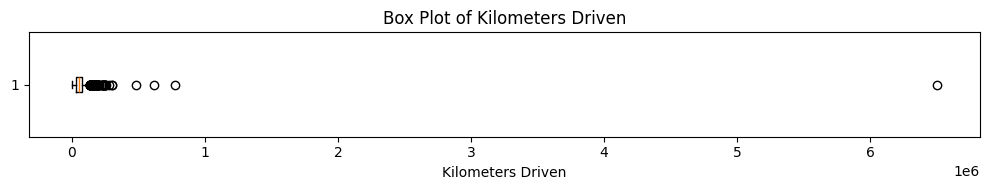

In [35]:
plt.figure(figsize=(10, 2))
plt.boxplot(df_train["Kilometers_Driven"], vert=False)
plt.xlabel("Kilometers Driven")
plt.title("Box Plot of Kilometers Driven")
plt.tight_layout()
plt.show()

There are clearly some extreme impossible data points. They should be clipped.


In [36]:
df_train.Kilometers_Driven = df_train.Kilometers_Driven.clip(
    upper=int(df_train.Kilometers_Driven.quantile(0.995))
)
df_test.Kilometers_Driven = df_test.Kilometers_Driven.clip(
    upper=int(df_test.Kilometers_Driven.quantile(0.995))
)

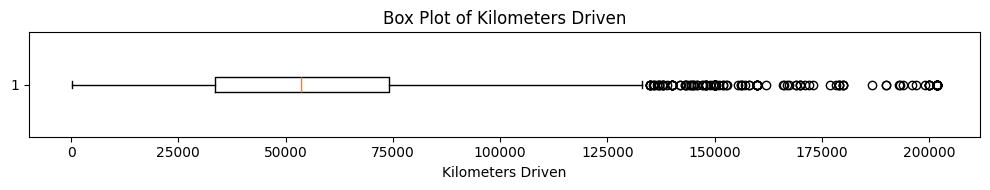

In [37]:
plt.figure(figsize=(10, 2))
plt.boxplot(df_train["Kilometers_Driven"], vert=False)
plt.xlabel("Kilometers Driven")
plt.title("Box Plot of Kilometers Driven")
plt.tight_layout()
plt.show()

In [38]:
class KilometersDrivenClipper(TransformerMixin, BaseEstimator):
    def __init__(
        self,
        kilometers_driven_col: str = "Kilometers_Driven",
        clipping_quantile: float = 0.995,
    ):
        self.kilometers_driven_col = kilometers_driven_col
        self.clipping_quantile = clipping_quantile

    def fit(
        self, X: pd.DataFrame, y: Optional[pd.Series] = None
    ) -> "KilometersDrivenClipper":
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        X[self.kilometers_driven_col] = X[self.kilometers_driven_col].clip(
            upper=int(X[self.kilometers_driven_col].quantile(self.clipping_quantile))
        )
        return X


1. `Kilometers_Driven`


1. `Kilometers_Driven` Outliers clipped


In [39]:
kilometers_driven_outlier_clip_exp = Experiment(
    ExperimentConfig(
        name="clipping-extreme-Kilometers_Driven",
        pipeline=Pipeline(
            [
                ("Kilometers_Driven_clip_outliers", KilometersDrivenClipper()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

kilometers_driven_outlier_clip_exp.run(X_train, y_train, X_test, baseline_exp_result);


[Experiment: clipping-extreme-Kilometers_Driven]
Cross-validating (5-folds)...
CV score: 0.1596 ± 0.0165
         -0.0010  +0.0002 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/clipping-extreme-Kilometers_Driven.csv
Experiment complete



The performance increased slightly but also increased std slightly. The effect is negligible but still good to have for numerical stability.


In [40]:
current_best_exp = Experiment(
    ExperimentConfig(
        name="current-best",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                (
                    "target_encode",
                    TargetEncoder(cols=["Brand", "Model", "Name", "Location"]),
                ),
                ("transform", YearToAgeTransformer()),
                ("Kilometers_Driven_clip_outliers", KilometersDrivenClipper()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

current_best_exp.run(X_train, y_train, None, baseline_exp_result);

[Experiment: current-best]
Cross-validating (5-folds)...
CV score: 0.1485 ± 0.0167
         -0.0121  +0.0004 compared to baseline (Negative is better)
Training on full training set...
Experiment complete



#### Fuel_Type


In [41]:
df_train.Fuel_Type.value_counts()

Fuel_Type
Diesel      2372
Petrol      2008
CNG           42
LPG            6
Electric       0
Name: count, dtype: int64

In [42]:
df_test.Fuel_Type.value_counts()

Fuel_Type
Diesel      790
Petrol      685
CNG          13
LPG           3
Electric      0
Name: count, dtype: int64

`Fuel_Type` has low cardinality but CNG, LPG, and Electric has extremely low datapoints. Grouping CNG, LPG, and Electric to Other could mitigate this problem.


In [43]:
class FuelTypeGrouper(TransformerMixin, BaseEstimator):
    def __init__(self, fuel_type_col: str = "Fuel_Type"):
        self.fuel_type_col = fuel_type_col

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series]) -> "FuelTypeGrouper":
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X[self.fuel_type_col] = (
            X[self.fuel_type_col]
            .astype("object")
            .replace({"CNG": "Other", "LPG": "Other", "Electric": "Other"})
            .astype("category")
        )
        return X

In [44]:
fuel_type_grouping_exp = Experiment(
    ExperimentConfig(
        name="grouping-infrequent-fuel-type",
        pipeline=Pipeline(
            [
                ("group_infrequent_fuel_type", FuelTypeGrouper()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

fuel_type_grouping_exp.run(X_train, y_train, X_test, baseline_exp_result);


[Experiment: grouping-infrequent-fuel-type]
Cross-validating (5-folds)...
CV score: 0.1601 ± 0.0150
         -0.0005  -0.0013 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/grouping-infrequent-fuel-type.csv
Experiment complete



Due to low cardinality, (Petrol / Disel / Other), I do not feel the need to engineer it further (e.g. target encoding).


In [45]:
current_best_exp = Experiment(
    ExperimentConfig(
        name="current-best",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                (
                    "target_encode",
                    TargetEncoder(cols=["Brand", "Model", "Name", "Location"]),
                ),
                ("transform", YearToAgeTransformer()),
                ("Kilometers_Driven_clip_outliers", KilometersDrivenClipper()),
                ("group_infrequent_fuel_type", FuelTypeGrouper()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

current_best_exp.run(X_train, y_train, None, baseline_exp_result);

[Experiment: current-best]
Cross-validating (5-folds)...
CV score: 0.1489 ± 0.0151
         -0.0117  -0.0012 compared to baseline (Negative is better)
Training on full training set...
Experiment complete



#### Transmission


In [46]:
df_train.Transmission.value_counts()

Transmission
Manual       3162
Automatic    1266
Name: count, dtype: int64

`Transmission` has two categories and well balanced. There is no need to engineer this feature alone further.


#### Owner Type


In [47]:
df_train.Owner_Type.cat.categories

Index(['First', 'Second', 'Third', 'Fourth & Above'], dtype='object')

In [48]:
df_train.Owner_Type.value_counts()

Owner_Type
First             3617
Second             715
Third               91
Fourth & Above       5
Name: count, dtype: int64

Based on common knowledge, `Owner_Type` might be one of the most significant predictor of `Price`.


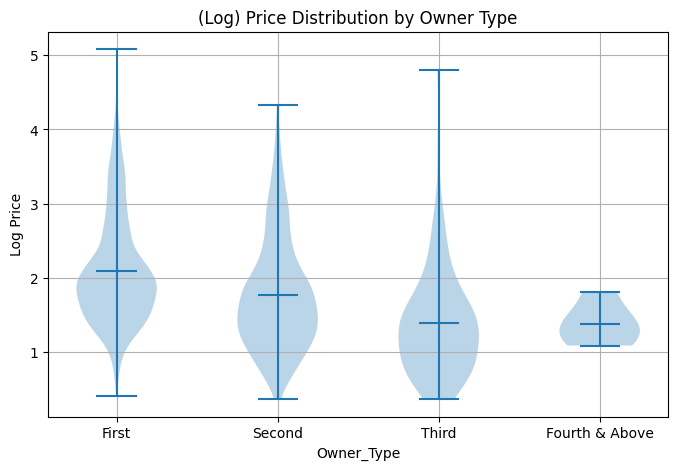

In [49]:
categories = list(df_train.Owner_Type.cat.categories)
plt.figure(figsize=(8, 5))
plt.violinplot(
    [
        np.log1p(df_train[df_train.Owner_Type == category]["Price"])
        for category in categories
    ],
    showmeans=True,
)
plt.xticks(ticks=range(1, len(categories) + 1), labels=categories)
plt.xlabel("Owner_Type")
plt.ylabel("Log Price")
plt.title("(Log) Price Distribution by Owner Type")
plt.grid(True)
plt.show()

Clearly, as `Owner_Type` increases, `Price` drops monotonically. (`Owner_Type` is already encoded as ordinal category in preprocessing). It is good enough for now.


#### Mileage


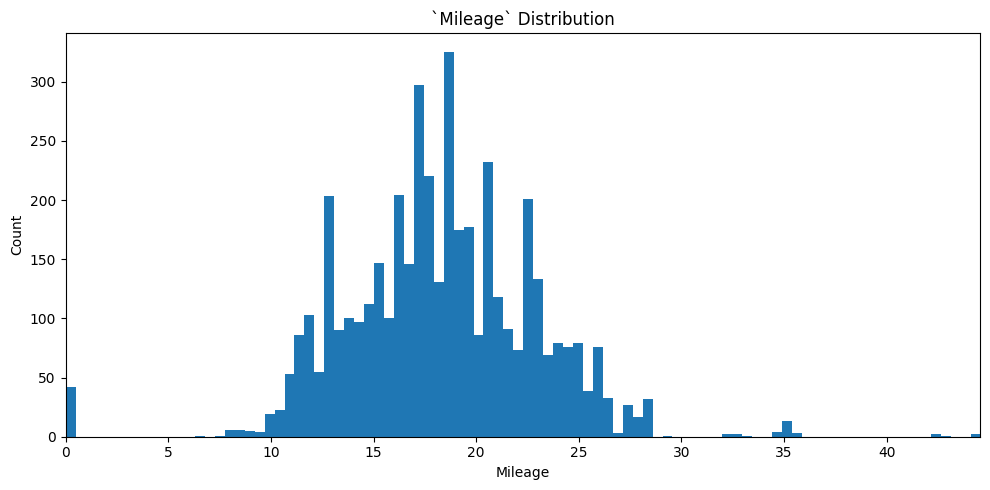

In [50]:
plt.figure(figsize=(10, 5))
plt.hist(df_train.Mileage, bins=100)
limit = np.percentile(df_train.Mileage, 99.9)
plt.xlim(0, limit)
plt.xlabel("Mileage")
plt.ylabel("Count")
plt.title("`Mileage` Distribution")

plt.tight_layout()
plt.show()


In [51]:
with pd.option_context("display.max_rows", None):
    display(df_train.Mileage.value_counts().sort_index())

Mileage
0.0000      42
6.4000       1
7.5000       1
7.8100       1
7.9400       2
8.0000       1
8.2000       2
8.4500       1
8.5000       1
8.6000       2
8.7000       2
9.0000       5
9.4300       1
9.5000       2
9.5200       1
9.7400       2
9.8000       3
9.9000       2
10.0000      5
10.1000      4
10.1300      3
10.2000      3
10.3700      2
10.4000      2
10.5000     16
10.8000      7
10.9000      6
10.9100     10
10.9300      5
10.9800      1
11.0000     14
11.0500      2
11.0700      1
11.1000      7
11.1800      6
11.2000      4
11.2500      2
11.3000      7
11.3300      5
11.3600     18
11.4000      4
11.4900      1
11.5000     31
11.5600      1
11.5700      6
11.6200      1
11.6800      4
11.7000     16
11.7200      2
11.7400     10
11.7900      4
11.8000      6
11.9000      3
12.0000     11
12.0500     27
12.0700     18
12.1000      2
12.1900      1
12.3000      4
12.3500      1
12.3900      5
12.4000      8
12.5000      3
12.5100      2
12.5500     26
12.6000      5
12

It is bell shaped as expected. However, the regular peaks hints that there was some bias towards round numbers.


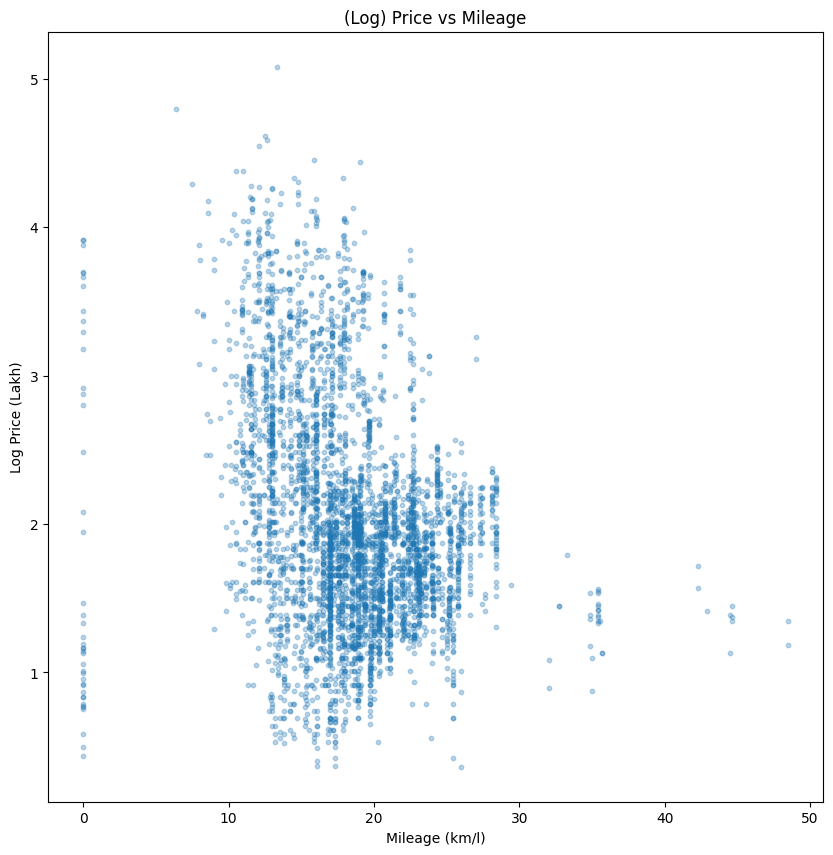

In [52]:
plt.figure(figsize=(10, 10))
plt.scatter(df_train.Mileage, np.log1p(df_train.Price), alpha=0.3, s=10)
plt.xlabel("Mileage (km/l)")
plt.ylabel("Log Price (Lakh)")
plt.title("(Log) Price vs Mileage")
plt.show()

`Mileage` alone does not show clear relationship with `Price`.

Cleaning up unrealistic outliers would stablize the model.


In [53]:
class MileageClipper(TransformerMixin, BaseEstimator):
    def __init__(
        self,
        mileage_col: str = "Mileage",
        clipping_quantile: float = 0.995,
    ):
        self.mileage_col = mileage_col
        self.clipping_quantile = clipping_quantile

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> "MileageClipper":
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        X[self.mileage_col] = X[self.mileage_col].clip(
            upper=int(X[self.mileage_col].quantile(self.clipping_quantile))
        )
        return X

In [54]:
mileage_outlier_clip_exp = Experiment(
    ExperimentConfig(
        name="clipping-extreme-mileage",
        pipeline=Pipeline(
            [
                ("mileage_clip_outliers", MileageClipper()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

mileage_outlier_clip_exp.run(X_train, y_train, X_test, baseline_exp_result);


[Experiment: clipping-extreme-mileage]
Cross-validating (5-folds)...
CV score: 0.1578 ± 0.0153
         -0.0028  -0.0010 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/clipping-extreme-mileage.csv
Experiment complete



In [55]:
current_best_exp = Experiment(
    ExperimentConfig(
        name="current-best",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                (
                    "target_encode",
                    TargetEncoder(cols=["Brand", "Model", "Name", "Location"]),
                ),
                ("transform", YearToAgeTransformer()),
                ("Kilometers_Driven_clip_outliers", KilometersDrivenClipper()),
                ("group_infrequent_fuel_type", FuelTypeGrouper()),
                ("mileage_clip_outliers", MileageClipper()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

current_best_exp.run(X_train, y_train, None, baseline_exp_result);

[Experiment: current-best]
Cross-validating (5-folds)...
CV score: 0.1484 ± 0.0143
         -0.0123  -0.0020 compared to baseline (Negative is better)
Training on full training set...
Experiment complete



#### Engine


In [56]:
df_train.Engine.describe()

count        4428.0
mean      1618.2771
std      595.245047
min           624.0
25%          1198.0
50%          1493.0
75%          1968.0
max          5998.0
Name: Engine, dtype: Float64

`Engine` feature seems reasonable enough.


#### Power


In [57]:
df_train.Power.describe()

count    4336.000000
mean      113.171817
std        53.875993
min        34.200000
25%        75.000000
50%        94.000000
75%       138.100000
max       560.000000
Name: Power, dtype: float64

`Power` featrue seems reasonable enough.

However, as explored in `preprocessing.ipynb`, the percentage of missin values in `Power` was non-negligible.


In [58]:
df_train[df_train.Power.isna()]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Colour,Seats,Doors,New_Price,Price
ID,,,,,,,,,,,,,,,
2CM572,Fiat Petra,Pune,2005,120000,Petrol,Manual,Second,15.50,1242,NaN,Others,5,4,NaN,0.85
4J1SFY,Mercedes-Benz E-Class,Pune,2001,121000,Diesel,Manual,First,15.00,2148,NaN,White,5,4,NaN,5.00
LHXSLV,Maruti Swift,Hyderabad,2014,81609,Diesel,Manual,First,17.80,1248,NaN,Others,5,4,NaN,5.55
R7UPR3,Fiat Siena,Jaipur,2001,70000,Petrol,Manual,Third,0.00,1242,NaN,White,5,4,NaN,0.55
KZI5XI,Skoda Laura,Pune,2010,85000,Petrol,Manual,First,17.50,1798,NaN,Black/Silver,5,4,NaN,2.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z3GW3N,Hyundai Santro,Hyderabad,2006,74483,Petrol,Automatic,First,0.00,999,NaN,Black/Silver,5,4,NaN,2.30
M49PV9,Hyundai Santro,Mumbai,2005,102000,Petrol,Manual,Second,17.00,1086,NaN,White,5,4,NaN,0.85
9BPQA2,Hyundai Santro,Pune,2005,100000,CNG,Manual,Third,22.61,1086,NaN,White,5,4,NaN,1.20


`Power` can be faithfully imputed exploiting its high relevance to `Engine`.


In [59]:
print(f"Engine-Power Correlation: {df_train.Engine.corr(df_train.Power):.2f}")

Engine-Power Correlation: 0.86


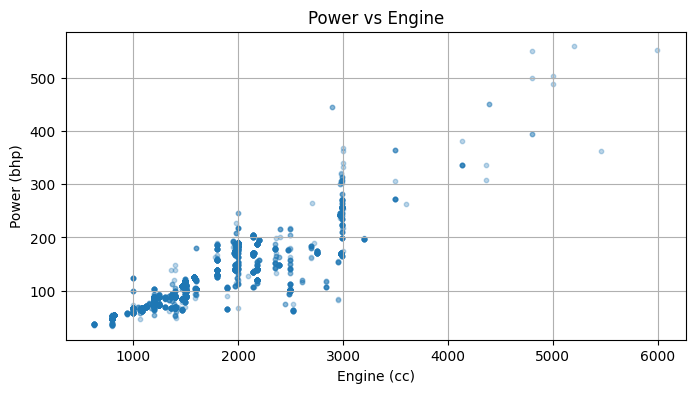

In [60]:
plt.figure(figsize=(8, 4))
plt.scatter(df_train["Engine"], df_train["Power"], alpha=0.3, s=10)

plt.xlabel("Engine (cc)")
plt.ylabel("Power (bhp)")
plt.title("Power vs Engine")
plt.grid(True)
plt.show()

In [61]:
class PowerImputer(TransformerMixin, BaseEstimator):
    def __init__(
        self, engine_col: str = "Engine", power_col="Power", clip_negative: bool = True
    ):
        self.engine_col = engine_col
        self.power_col = power_col
        self.clip_negative = clip_negative

    def fit(self, X: pd.DataFrame, y=Optional[pd.Series]) -> "PowerImputer":
        df = X[[self.engine_col, self.power_col]].dropna()
        engines = df[self.engine_col].astype(float)
        powers = df[self.power_col].astype(float)

        # Linear regression
        cov = ((engines - engines.mean()) * (powers - powers.mean())).sum()
        var = ((engines - engines.mean()) ** 2).sum()
        self.slope = cov / var
        self.intercept = powers.mean() - self.slope * engines.mean()

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        mask = X[self.power_col].isna()
        has_engine = X[self.engine_col].notna() & mask
        X.loc[has_engine, self.power_col] = (
            self.slope * X.loc[has_engine, self.engine_col] + self.intercept
        )

        if self.clip_negative:
            X[self.power_col] = X[self.power_col].clip(lower=0)

        return X

In [62]:
power_imputation_exp = Experiment(
    ExperimentConfig(
        name="power-imputation",
        pipeline=Pipeline(
            [
                ("imput_power", PowerImputer()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

power_imputation_exp.run(X_train, y_train, X_test, baseline_exp_result);

[Experiment: power-imputation]
Cross-validating (5-folds)...
CV score: 0.1551 ± 0.0159
         -0.0055  -0.0004 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/power-imputation.csv
Experiment complete



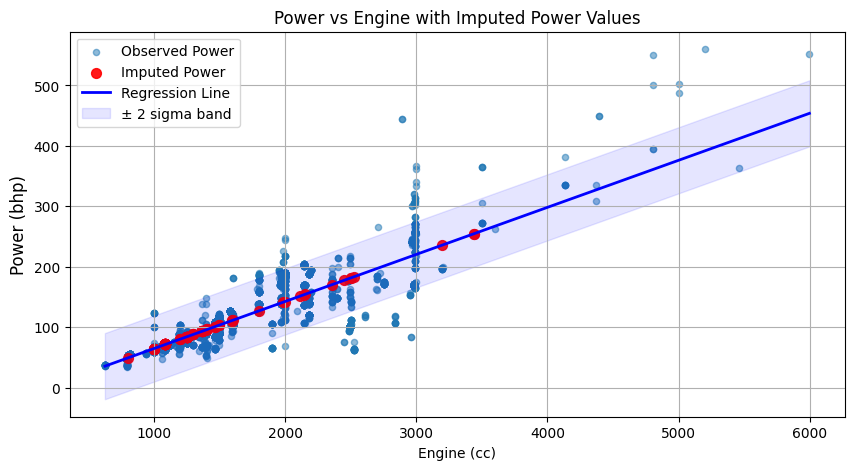

In [63]:
imputer = PowerImputer()
imputer.fit(X_train)

slope = imputer.slope
intercept = imputer.intercept

df_plot = X_train.copy()
df_plot["imputed_Power"] = imputer.transform(X_train)[imputer.power_col]
df_plot["missing_Power"] = df_plot.Power.isna()

engine_range = np.linspace(df_plot.Engine.min(), df_plot.Engine.max(), 200)
regression_line = slope * engine_range + intercept

observed_mask = ~df_plot.missing_Power

df_observed = df_plot.loc[observed_mask]
residuals = df_observed.Power - (slope * df_observed.Engine + intercept)
sigma = residuals.std()

plt.figure(figsize=(10, 5))
plt.scatter(
    df_plot.loc[observed_mask, "Engine"],
    df_plot.loc[observed_mask, "Power"],
    s=20,
    alpha=0.5,
    label="Observed Power",
)
plt.scatter(
    df_plot.loc[df_plot.missing_Power, "Engine"],
    df_plot.loc[df_plot.missing_Power, "imputed_Power"],
    s=50,
    color="red",
    alpha=0.9,
    label="Imputed Power",
)
plt.plot(
    engine_range, regression_line, color="blue", linewidth=2, label="Regression Line"
)
plt.fill_between(
    engine_range,
    regression_line - 2 * sigma,
    regression_line + 2 * sigma,
    color="blue",
    alpha=0.1,
    label="± 2 sigma band",
)

plt.xlabel("Engine (cc)", fontsize=10)
plt.ylabel("Power (bhp)", fontsize=12)
plt.title("Power vs Engine with Imputed Power Values")
plt.legend()
plt.grid(True)
plt.show()

Missing `Power` was effectively imputed with its highly linear correlation with `Engine`.


Combining all featrue engineering so far.


In [64]:
df_train.columns

Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Colour',
       'Seats', 'Doors', 'New_Price', 'Price'],
      dtype='object')

In [65]:
current_best_exp = Experiment(
    ExperimentConfig(
        name="current-best",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                (
                    "target_encode",
                    TargetEncoder(cols=["Brand", "Model", "Name", "Location"]),
                ),
                ("transform", YearToAgeTransformer()),
                ("Kilometers_Driven_clip_outliers", KilometersDrivenClipper()),
                ("group_infrequent_fuel_type", FuelTypeGrouper()),
                ("mileage_clip_outliers", MileageClipper()),
                ("imput_power", PowerImputer()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    ),
)

current_best_exp.run(X_train, y_train, None, baseline_exp_result);


[Experiment: current-best]
Cross-validating (5-folds)...
CV score: 0.1466 ± 0.0165
         -0.0140  +0.0002 compared to baseline (Negative is better)
Training on full training set...
Experiment complete



#### Colour


In [66]:
df_train.Colour.describe()

count      4428
unique        3
top       White
freq       1539
Name: Colour, dtype: object

In [67]:
df_train.Colour.value_counts()

Colour
White           1539
Others          1519
Black/Silver    1370
Name: count, dtype: int64

`Colour` is already well balanced.


### Seats


In [68]:
df_train.Seats.value_counts()

Seats
5     3736
7      503
8       83
4       69
6       21
2       12
10       2
9        2
Name: count, dtype: Int64

Binning could help for those rare seat counts. However, the binning should not break the ordinality.


In [69]:
class SeatsBinner(TransformerMixin, BaseEstimator):
    def __init__(self, seats_col: str = "Seats"):
        self.seats_col = seats_col

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series]) -> "SeatsBinner":
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        seats = X[self.seats_col]

        X[self.seats_col] = seats.replace(
            {
                2: 4,
                4: 4,
                # Small
                5: 5,
                # Standard
                6: 7,
                7: 7,
                8: 7,
                # Large
                9: 9,
                10: 9,
                # Van
            }
        )

        return X

In [70]:
seats_binning_exp = Experiment(
    ExperimentConfig(
        name="bin-seats",
        pipeline=Pipeline(
            [
                ("bin_seats", SeatsBinner()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

seats_binning_exp.run(X_train, y_train, X_test, baseline_exp_result);


[Experiment: bin-seats]
Cross-validating (5-folds)...
CV score: 0.1581 ± 0.0154
         -0.0025  -0.0009 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/bin-seats.csv
Experiment complete



Binning `Seats` had positive effect on the prediction score.


In [71]:
current_best_exp = Experiment(
    ExperimentConfig(
        name="current-best",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                (
                    "target_encode",
                    TargetEncoder(cols=["Brand", "Model", "Name", "Location"]),
                ),
                ("transform", YearToAgeTransformer()),
                ("Kilometers_Driven_clip_outliers", KilometersDrivenClipper()),
                ("group_infrequent_fuel_type", FuelTypeGrouper()),
                ("mileage_clip_outliers", MileageClipper()),
                ("imput_power", PowerImputer()),
                ("bin_seats", SeatsBinner()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

current_best_exp.run(X_train, y_train, None, baseline_exp_result);


[Experiment: current-best]
Cross-validating (5-folds)...
CV score: 0.1479 ± 0.0159
         -0.0127  -0.0004 compared to baseline (Negative is better)
Training on full training set...
Experiment complete



#### Doors


In [72]:
df_train.Doors.value_counts()

Doors
4    3884
5     532
2      12
Name: count, dtype: Int64

There are very small number of cars with 2 doors. However, I think it should not be binned, since usually cars with 2 doors are very expensive sports car, and it can imply a lot, even though it has very small sample size.


In [73]:
df_train[df_train.Doors == 2][["Name", "Engine", "Power", "Seats", "Doors"]]

,Name,Engine,Power,Seats,Doors
ID,,,,,
UFNCV8,BMW Z4,2979,306.00,2,2
ICAVC1,Jaguar F,5000,488.10,2,2
YDPHR8,Smart Fortwo,799,NaN,2,2
RS5FNO,Audi A4,3197,NaN,2,2
X5JJRY,Porsche Boxster,2706,265.00,2,2
2OAGHR,Porsche Cayman,3436,NaN,2,2
0RNZ4O,Porsche Cayman,3436,NaN,2,2
W15E5A,Mercedes-Benz SLK-Class,3498,306.00,2,2
NF6IF1,BMW Z4,2979,306.00,2,2


#### New_Price


In [74]:
print(
    f"# of missing New_Price: {len(df_train[df_train.New_Price.isna()])} out of {len(df_train)}"
)

# of missing New_Price: 3827 out of 4428


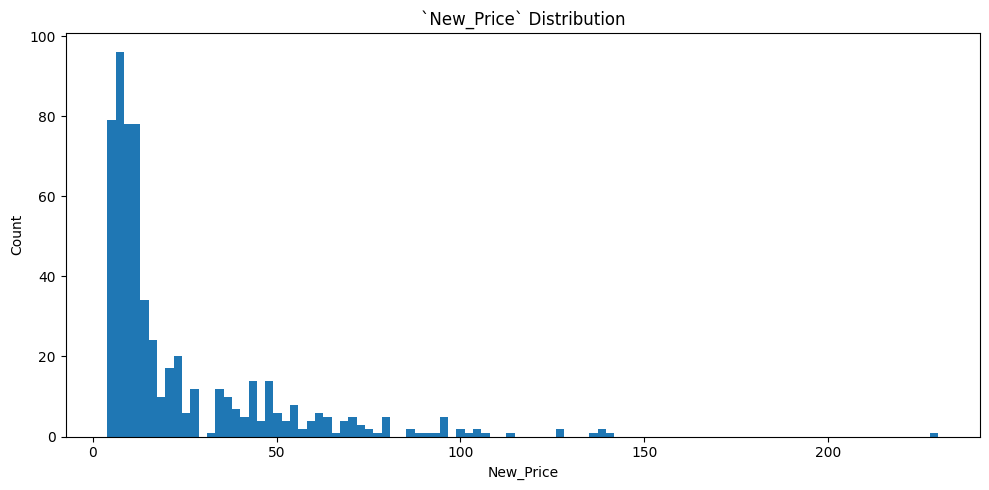

In [75]:
observed_new_prices = df_train[df_train.New_Price.notna()].New_Price

plt.figure(figsize=(10, 5))
plt.hist(observed_new_prices, bins=100)
plt.xlabel("New_Price")
plt.ylabel("Count")
plt.title("`New_Price` Distribution")

plt.tight_layout()
plt.show()

Due to its high sparsity, it would be dangerous to impute naively. Instead, labeling missing New_Price might give non-trivial information from the pattern of missing New_Price. Additionally, log transformation could help the heavy skew in its distribution.


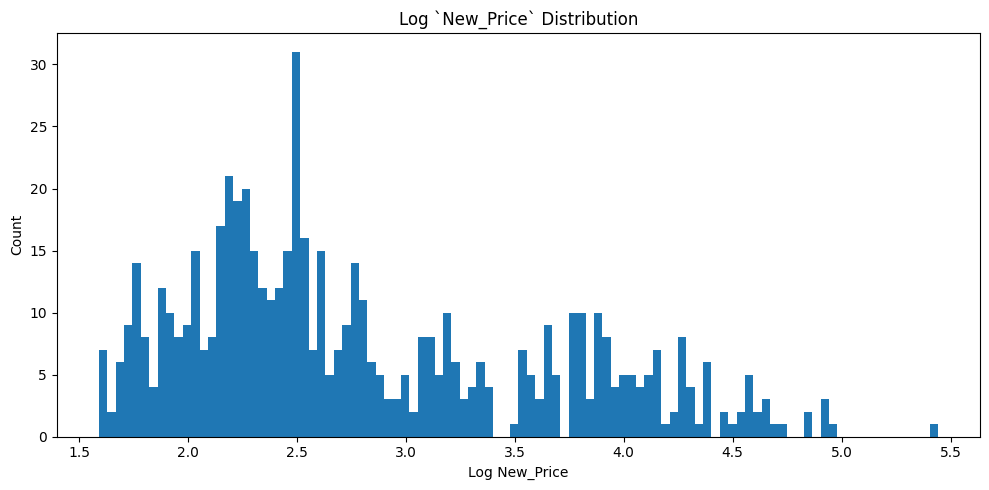

In [76]:
observed_new_prices = df_train[df_train.New_Price.notna()].New_Price

plt.figure(figsize=(10, 5))
plt.hist(np.log1p(observed_new_prices), bins=100)
plt.xlabel("Log New_Price")
plt.ylabel("Count")
plt.title("Log `New_Price` Distribution")

plt.tight_layout()
plt.show()

In [77]:
class NewPriceTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, new_price_col: str = "New_Price"):
        self.new_price_col = new_price_col
        self.missing_col = "Missing_" + new_price_col

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series]) -> "NewPriceTransformer":
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        X[self.missing_col] = X[self.new_price_col].isna().astype(int)

        X[self.new_price_col] = X[self.new_price_col].apply(np.log1p)

        return X

In [78]:
new_price_transform_exp = Experiment(
    ExperimentConfig(
        name="transform-new-price",
        pipeline=Pipeline(
            [
                ("transform_new_price", NewPriceTransformer()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

new_price_transform_exp.run(X_train, y_train, X_test, baseline_exp_result);


[Experiment: transform-new-price]
Cross-validating (5-folds)...
CV score: 0.1606 ± 0.0163
         +0.0000  +0.0000 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/transform-new-price.csv
Experiment complete



It did not yield visible gain. However, I'll keep it since this transformation can be useful in making interaction features. Should be judged later.


In [79]:
current_best_exp = Experiment(
    ExperimentConfig(
        name="current-best",
        pipeline=Pipeline(
            [
                ("extract_brand_model", BrandModelExtractor()),
                (
                    "target_encode",
                    TargetEncoder(cols=["Brand", "Model", "Name", "Location"]),
                ),
                ("transform", YearToAgeTransformer()),
                ("Kilometers_Driven_clip_outliers", KilometersDrivenClipper()),
                ("group_infrequent_fuel_type", FuelTypeGrouper()),
                ("mileage_clip_outliers", MileageClipper()),
                ("imput_power", PowerImputer()),
                ("bin_seats", SeatsBinner()),
                ("transform_new_price", NewPriceTransformer()),
                ("category_encode", CategoricalEncoder()),
                ("model", XGBRegressor()),
            ]
        ),
    )
)

current_best_exp.run(X_train, y_train, None, baseline_exp_result);

[Experiment: current-best]
Cross-validating (5-folds)...
CV score: 0.1479 ± 0.0159
         -0.0127  -0.0004 compared to baseline (Negative is better)
Training on full training set...
Experiment complete



#### Price


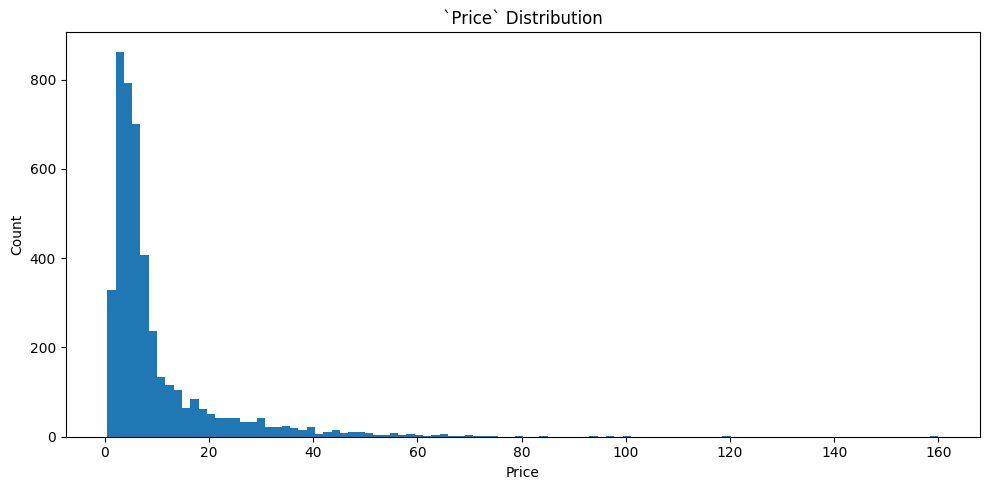

In [80]:
plt.figure(figsize=(10, 5))
plt.hist(df_train.Price, bins=100)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("`Price` Distribution")

plt.tight_layout()
plt.show()

The target feature `Price` is heavily skewed. Log transformation can mediate this.


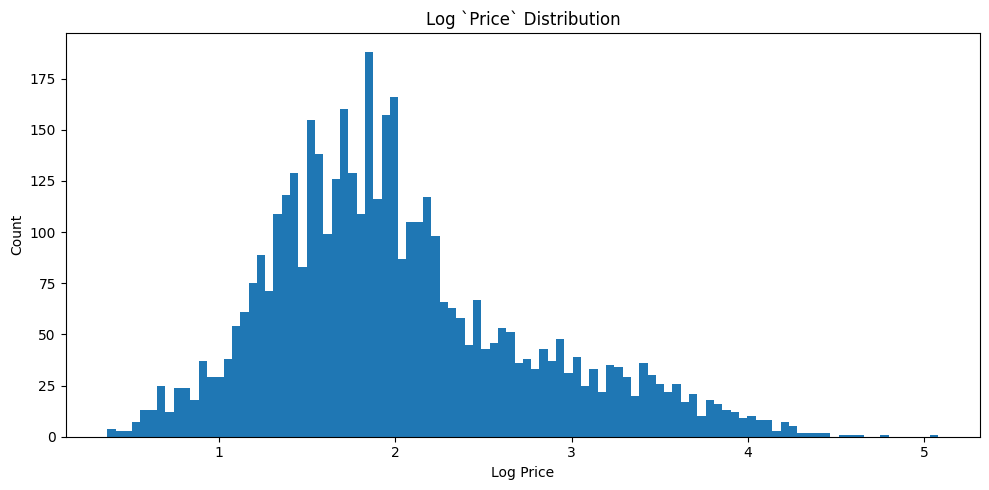

In [81]:
plt.figure(figsize=(10, 5))
plt.hist(np.log1p(df_train.Price), bins=100)
plt.xlabel("Log Price")
plt.ylabel("Count")
plt.title("Log `Price` Distribution")

plt.tight_layout()
plt.show()

In [82]:
price_transform_exp = Experiment(
    ExperimentConfig(
        name="transform-price",
        pipeline=Pipeline(
            [
                ("category_encode", CategoricalEncoder()),
                (
                    "model",
                    TransformedTargetRegressor(
                        regressor=XGBRegressor(), func=np.log1p, inverse_func=np.expm1
                    ),
                ),
            ]
        ),
    )
)

price_transform_exp.run(X_train, y_train, X_test, baseline_exp_result);


[Experiment: transform-price]
Cross-validating (5-folds)...
CV score: 0.1456 ± 0.0170
         -0.0150  +0.0007 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/transform-price.csv
Experiment complete



Log transformation on `Price` was very effective.


---

### Combining best transformations for each features


In [83]:
best_single_feature_pipeline = Pipeline(
    [
        ("extract_brand_model", BrandModelExtractor()),
        (
            "target_encode",
            TargetEncoder(cols=["Brand", "Model", "Name", "Location"]),
        ),
        ("transform", YearToAgeTransformer()),
        ("Kilometers_Driven_clip_outliers", KilometersDrivenClipper()),
        ("group_infrequent_fuel_type", FuelTypeGrouper()),
        ("mileage_clip_outliers", MileageClipper()),
        ("imput_power", PowerImputer()),
        ("bin_seats", SeatsBinner()),
        ("transform_new_price", NewPriceTransformer()),
        ("category_encode", CategoricalEncoder()),
        (
            "model",
            TransformedTargetRegressor(
                regressor=XGBRegressor(), func=np.log1p, inverse_func=np.expm1
            ),
        ),
    ]
)

In [84]:
best_feature_by_feature_exp = Experiment(
    ExperimentConfig(
        name="combine-all-feature-by-feature-engineering",
        pipeline=best_single_feature_pipeline,
    )
)

best_feature_by_feature_exp_result = best_feature_by_feature_exp.run(
    X_train, y_train, X_test, baseline_exp_result
)

[Experiment: combine-all-feature-by-feature-engineering]
Cross-validating (5-folds)...
CV score: 0.1379 ± 0.0173
         -0.0228  +0.0010 compared to baseline (Negative is better)
Training on full training set...
Creating submission on test set...
Submission created: artifacts/experiment-results/combine-all-feature-by-feature-engineering.csv
Experiment complete



---


### Interactions


To determine which interactions are worth investigating, I first perform residual diagnostics.


In [85]:
best_single_feature_pipeline.fit(X_train, y_train)

prediction_by_best_single_feature_pipeline = pd.Series(
    best_single_feature_pipeline.predict(X_train), index=y_train.index
)
residuals = y_train - prediction_by_best_single_feature_pipeline

X_train_transformed = pd.DataFrame(
    best_single_feature_pipeline[:-1].fit_transform(X_train, y_train)
)
y_train_transformed = y_train.apply(np.log10)

df_residuals = X_train_transformed.copy()
df_residuals["Residual"] = residuals
df_residuals["Prediction"] = prediction_by_best_single_feature_pipeline
df_residuals["Price"] = y_train

df_residuals

,Name,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Colour,Seats,Doors,New_Price,Brand,Model,Age,Missing_New_Price,Residual,Prediction,Price
ID,,,,,,,,,,,,,,,,,,,,
G4XLU0,4.267524,15.550690,59138,0,1,0,17.00,1405,70.00,1,5,4,NaN,3.417323,4.267524,7,1,0.021814,2.558186,2.58
CRSHOS,7.206730,11.252232,81504,0,1,0,21.43,1364,87.20,1,5,4,NaN,11.417767,7.206730,7,1,-0.088608,6.618608,6.53
FUJ4X1,6.443593,10.093132,92000,2,1,0,13.80,1299,70.00,1,5,4,NaN,6.549908,6.443593,13,1,-0.100111,1.350111,1.25
QMVK6E,5.077432,5.460807,33249,0,1,0,21.27,1396,88.76,0,5,4,NaN,5.333501,5.077432,8,1,-0.016794,3.266794,3.25
4SWHFC,5.867476,12.628270,65000,2,1,0,17.00,1497,118.00,2,5,4,NaN,5.425303,5.867476,9,1,0.109849,5.090151,5.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TR7SLB,10.542137,11.252232,51884,0,1,0,16.00,2179,140.00,2,7,5,NaN,8.075126,10.542137,4,1,0.440084,12.019916,12.46
QB41QE,6.497267,5.460807,27210,0,1,0,27.30,1498,98.60,1,5,4,NaN,5.425303,6.497267,4,1,-0.017071,5.867071,5.85
ODG8N7,33.110594,6.749484,52000,0,0,0,12.70,2179,187.70,2,5,4,NaN,37.771935,33.110594,5,1,0.467415,39.282585,39.75


In [86]:
def residual_plot(feature, bins=False):
    plt.figure(figsize=(10, 10 if bins else 5))
    x = df_residuals[feature][df_residuals[feature].notna()]
    if bins:
        sns.boxplot(x=x, y=df_residuals["Residual"])
    else:
        sns.scatterplot(
            x=x,
            y=df_residuals["Residual"],
            alpha=0.5,
            s=20,
        )
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"Residual vs {feature}")
    plt.show()

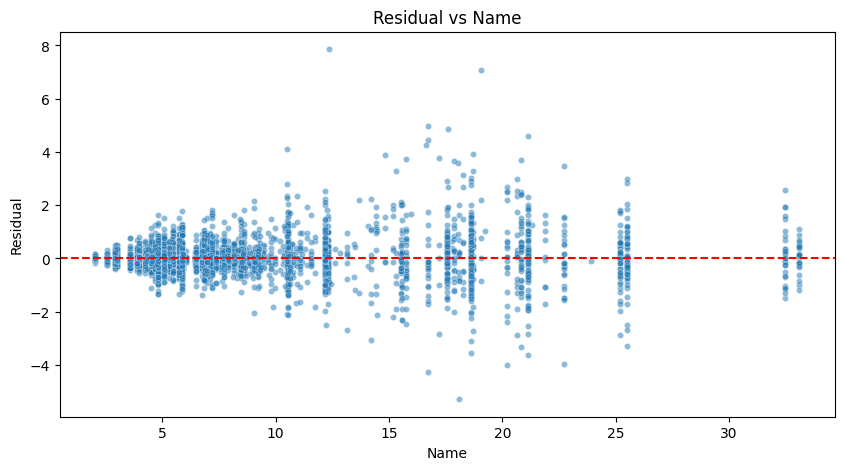

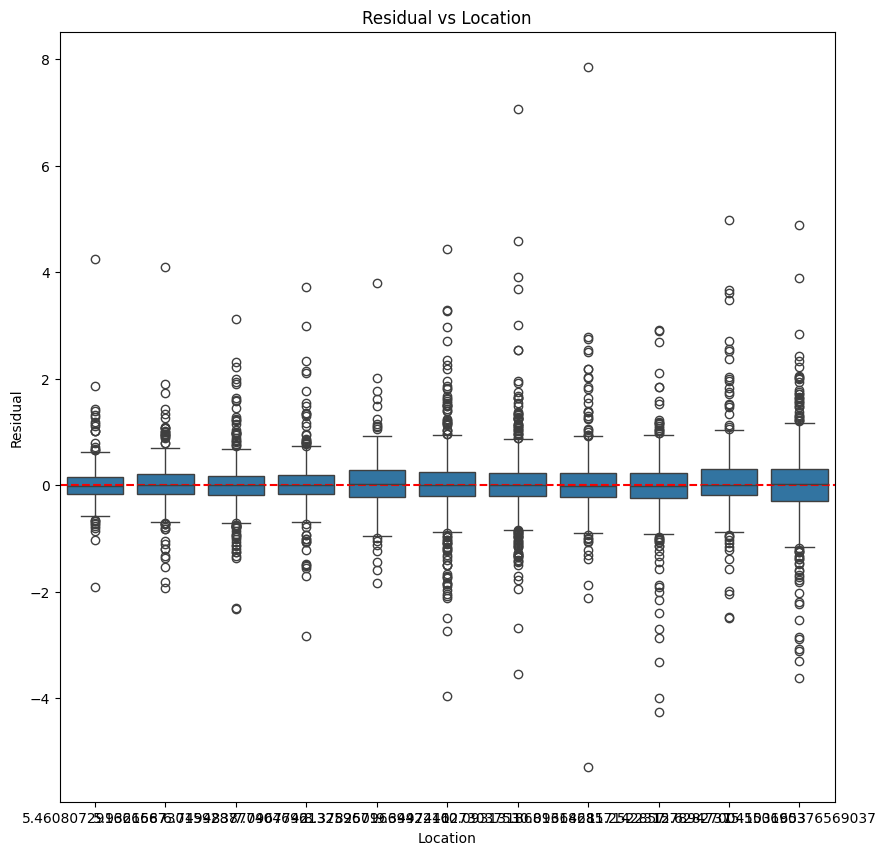

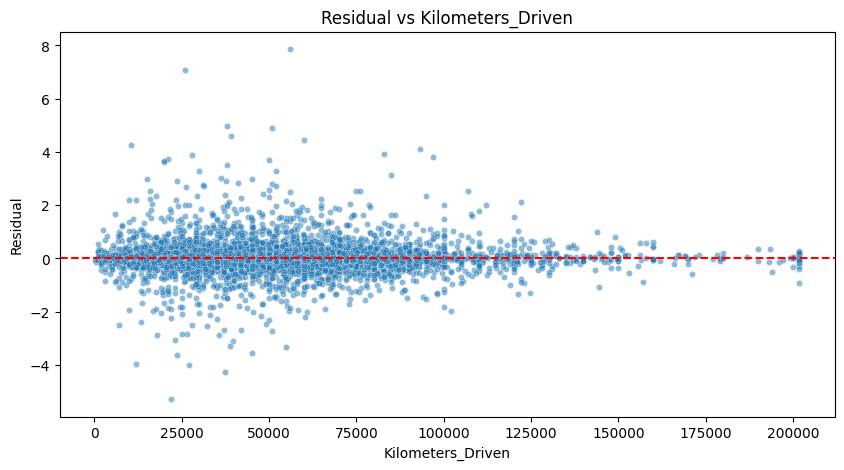

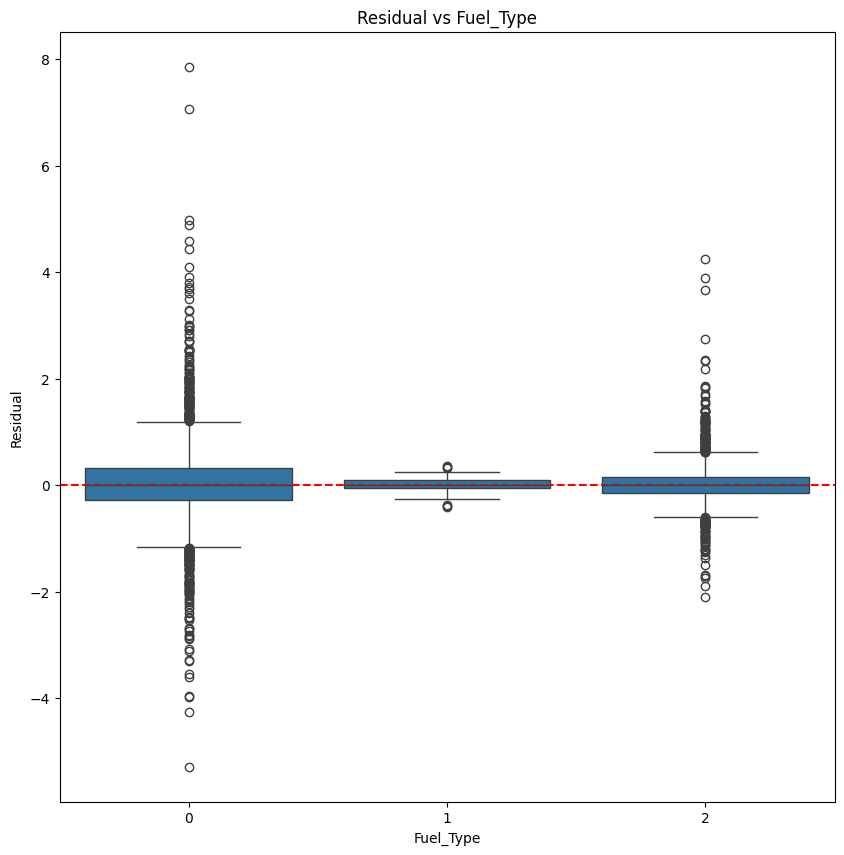

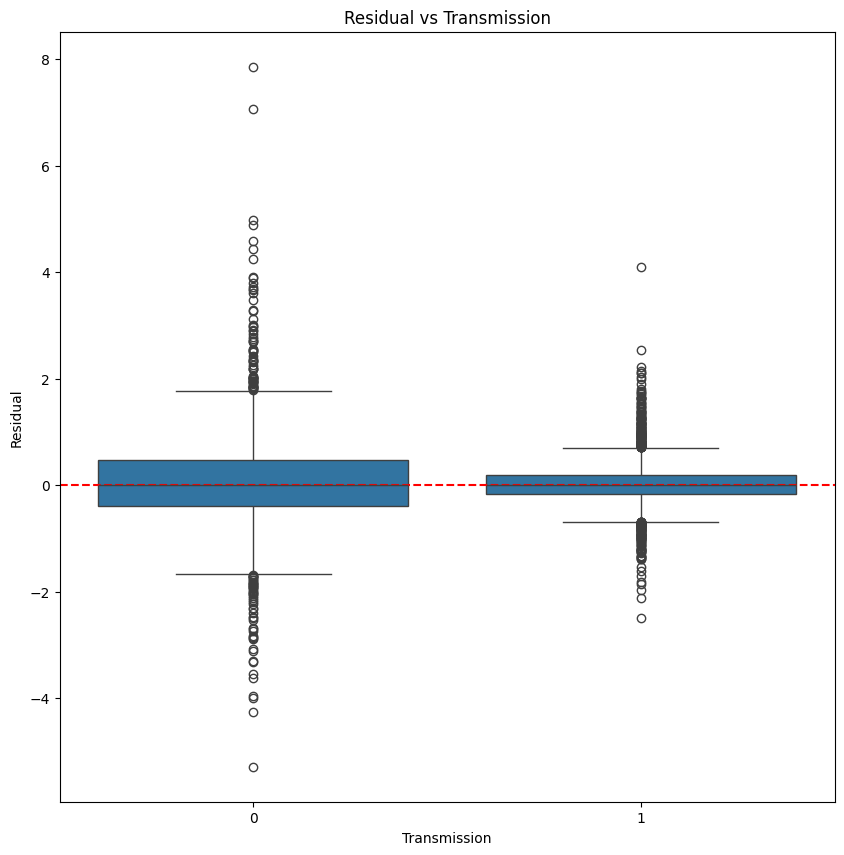

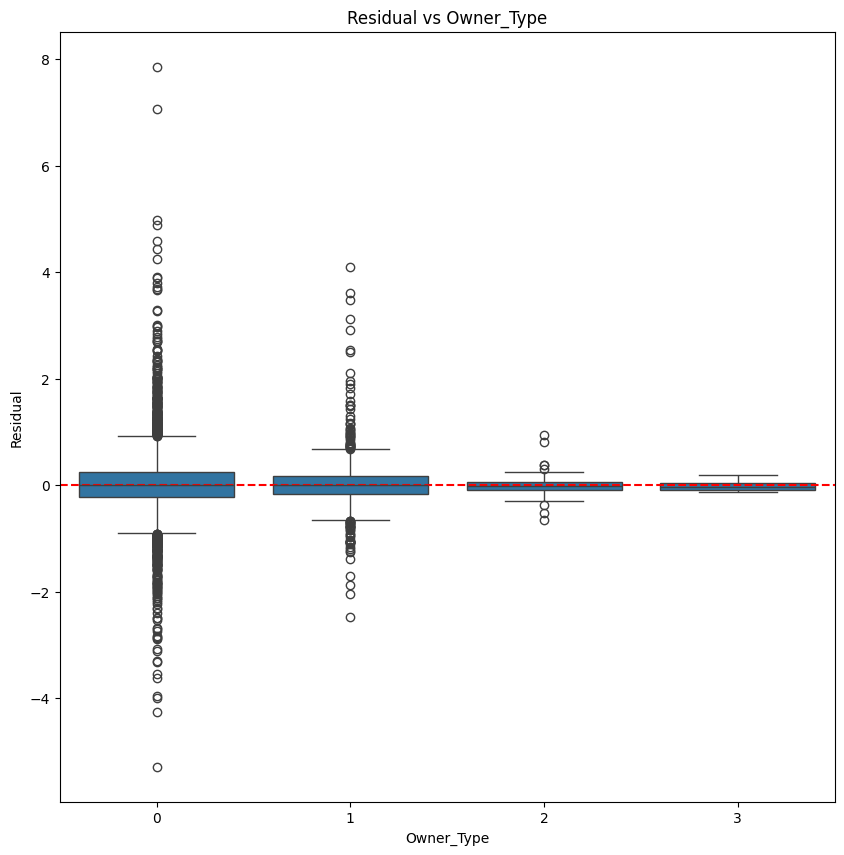

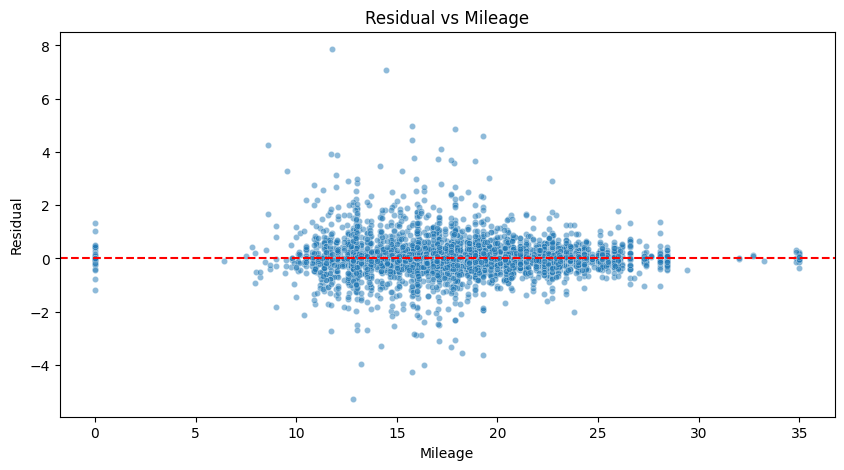

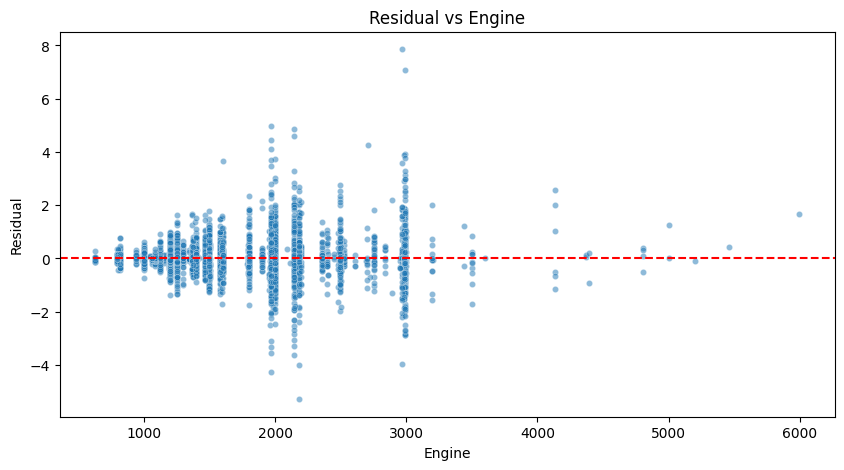

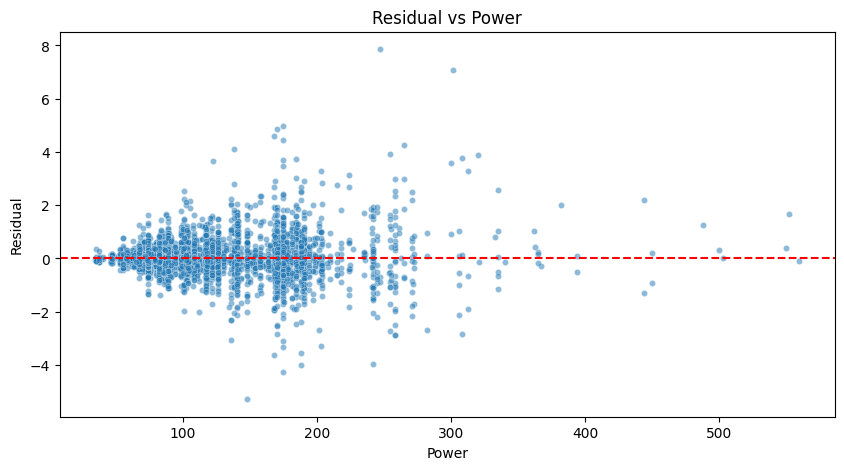

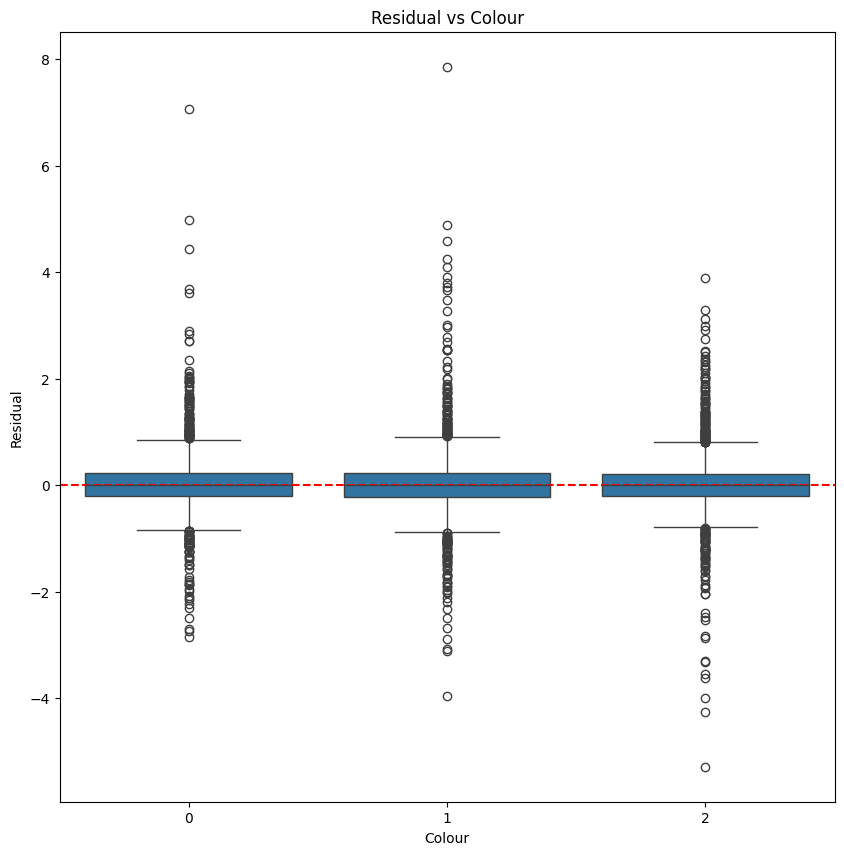

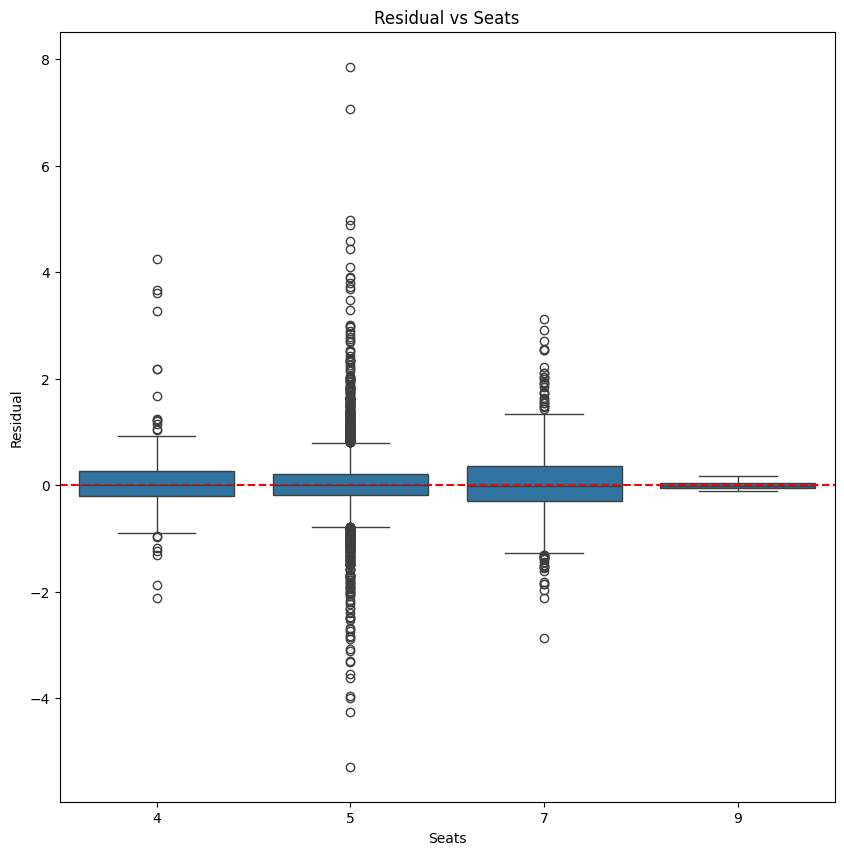

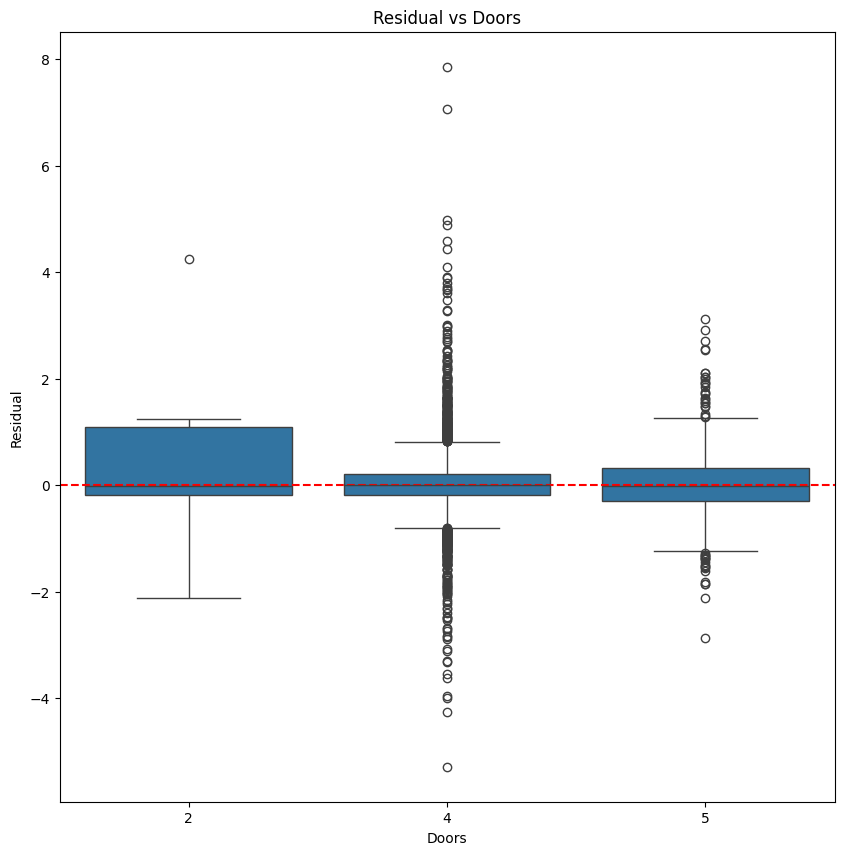

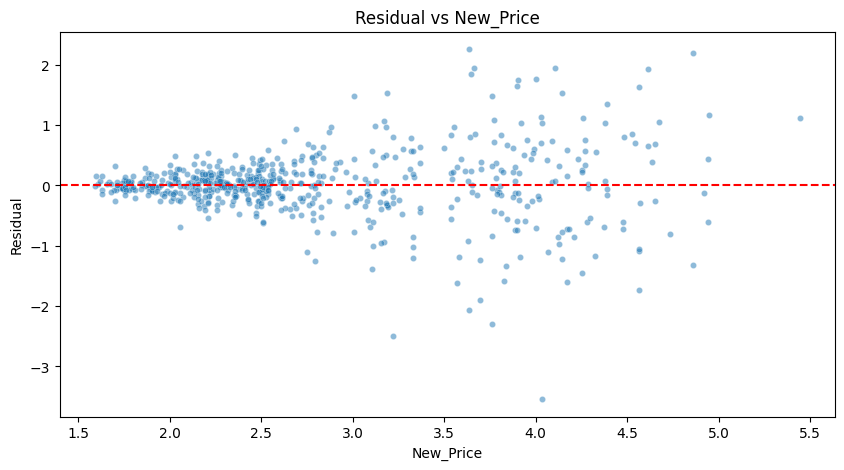

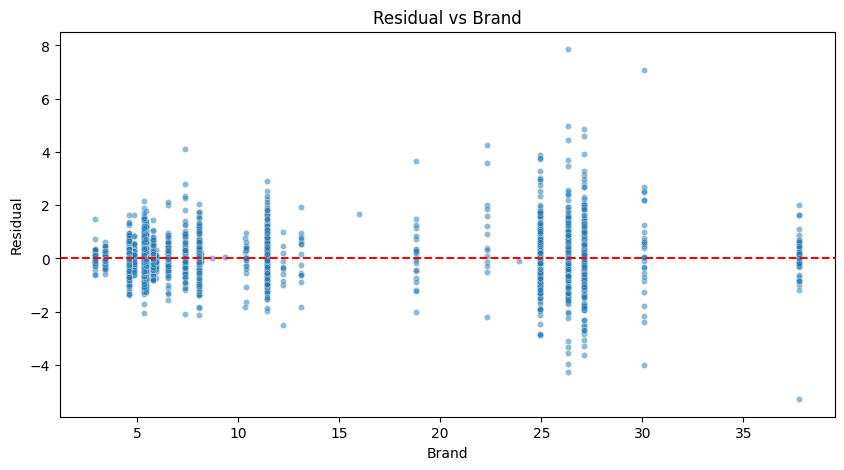

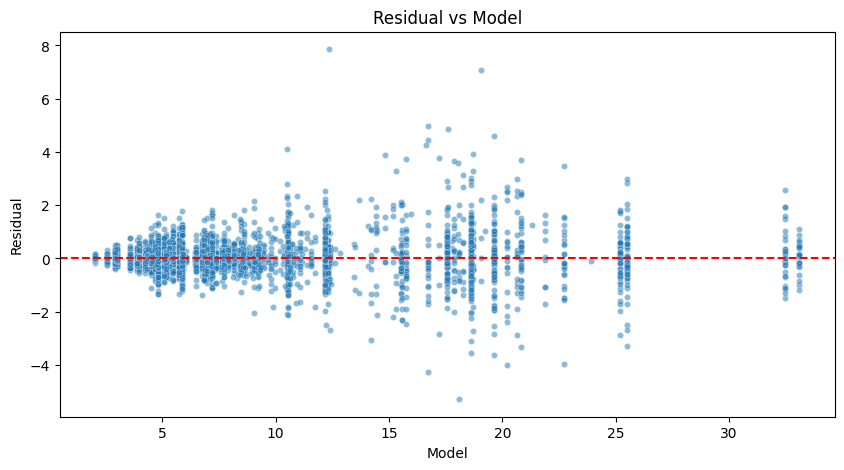

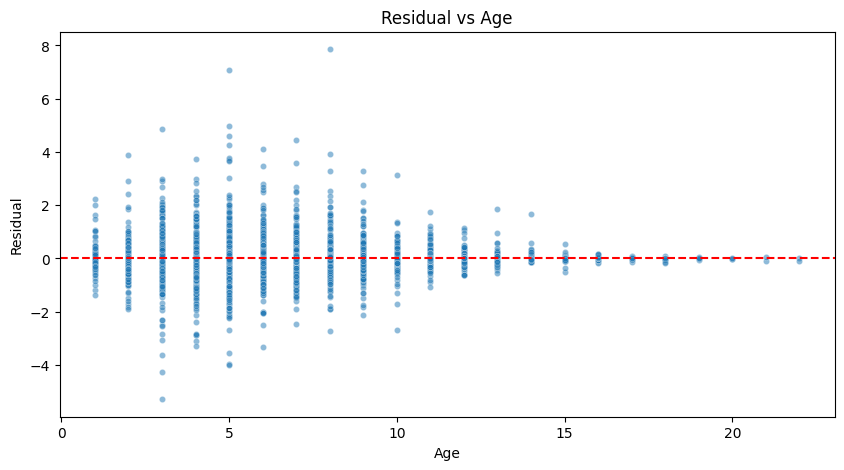

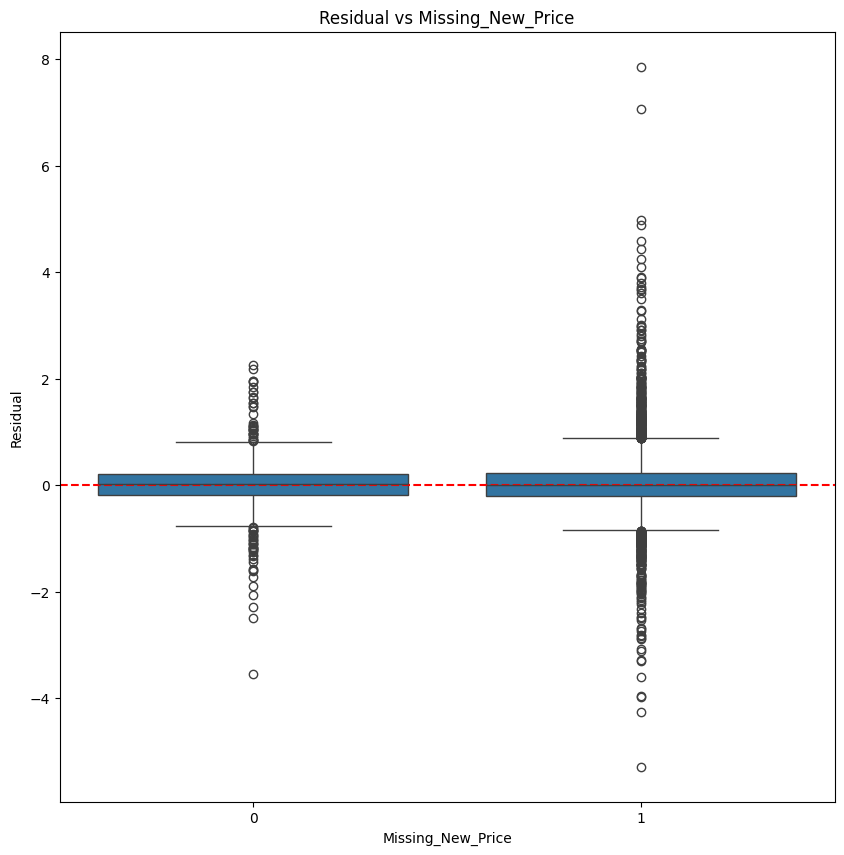

In [87]:
for feature in df_residuals.drop(columns=["Residual", "Price", "Prediction"]).columns:
    use_box_plot = (
        True
        if len(df_residuals[feature].unique()) < 15
        or df_residuals[feature].dtype.name == "category"
        else False
    )
    residual_plot(feature, bins=use_box_plot)

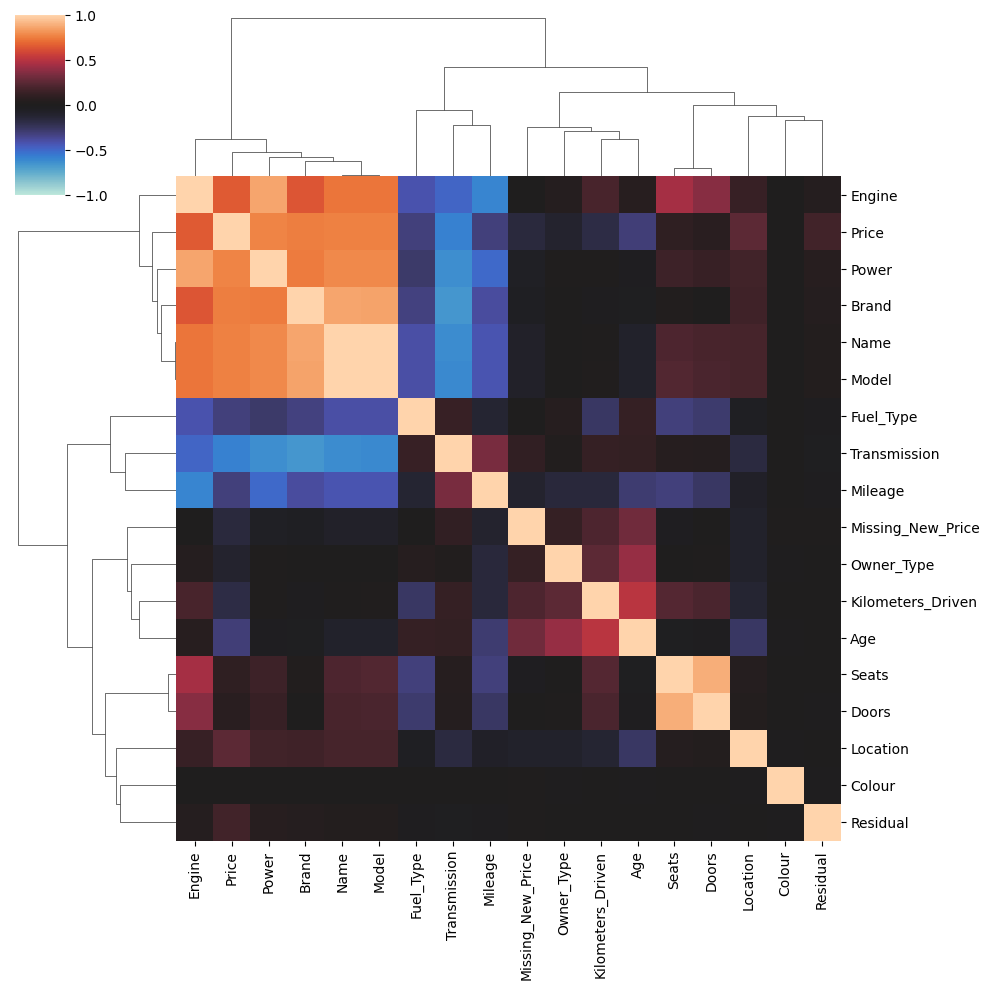

In [88]:
def plot_correlation(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


plot_correlation(df_residuals.drop(columns=["New_Price", "Prediction"]), annot=False)

There is highly correlated block.


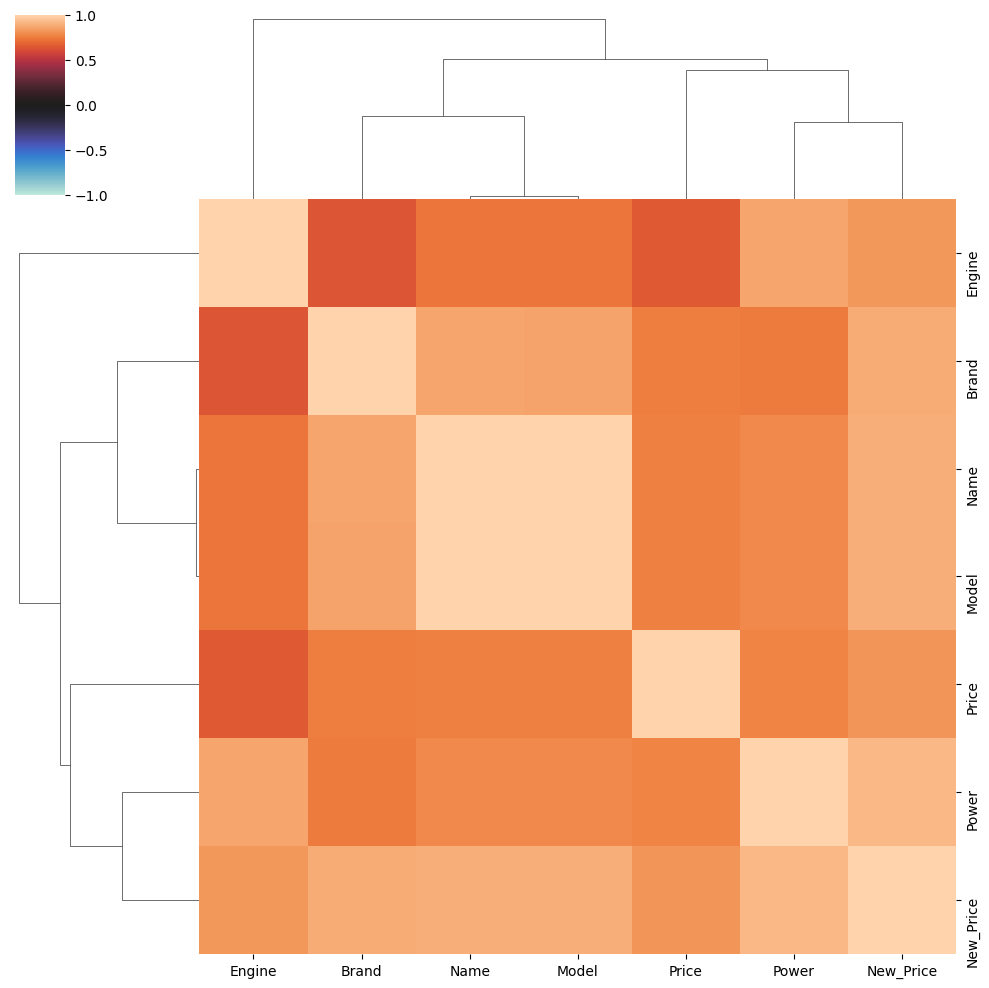

In [89]:
plot_correlation(
    df_residuals.drop(
        columns=[
            "Prediction",
            "Transmission",
            "Mileage",
            "Location",
            "Fuel_Type",
            "Seats",
            "Doors",
            "Missing_New_Price",
            "Owner_Type",
            "Kilometers_Driven",
            "Age",
            "Colour",
            "Residual",
        ]
    ),
    annot=False,
)

#### Brand $\times$ Engine


The residual correlation matrix strongly suggests correlation between `Brand` and `Engine`. This is plausible since the `Engine` given a `Brand` can give a strong signal on its tier within the `Brand`.


In [90]:
class BrandEngineInteraction(TransformerMixin, BaseEstimator):
    def __init__(
        self,
        brand_col: str = "Brand",
        engine_col: str = "Engine",
        brand_engine_col: str = "Brand-Engine",
    ):
        self.brand_col = brand_col
        self.engine_col = engine_col
        self.brand_engine_col = brand_engine_col

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series]) -> "BrandEngineInteraction":
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X[self.brand_engine_col] = X[self.brand_col] * X[self.engine_col]
        return X

In [91]:
brand_engine_interaction_exp = Experiment(
    ExperimentConfig(
        name="brand_engine_interaction",
        pipeline=Pipeline(
            [
                *best_single_feature_pipeline.steps[:-2],
                ("brand_engine_interaction", BrandEngineInteraction()),
                *best_single_feature_pipeline.steps[-2:],
            ]
        ),
    )
)

brand_engine_interaction_exp.run(
    X_train, y_train, None, best_feature_by_feature_exp_result
);

[Experiment: brand_engine_interaction]
Cross-validating (5-folds)...
CV score: 0.1382 ± 0.0161
         +0.0004  -0.0012 compared to combine-all-feature-by-feature-engineering (Negative is better)
Training on full training set...
Experiment complete



It decreased the performance. This could be due to XGBoost already capturing such interaction implicitly, and the introduction of this interaction featrue did not bring meaningfully more information.


#### `Brand` $\times$ `Power`


Similarly, `Brand` and `Power` shows strong correlation and this is plausible with the same reason as why `Brand` and `Engine` interaction is meaningful.


In [92]:
class BrandPowerInteraction(TransformerMixin, BaseEstimator):
    def __init__(
        self,
        brand_col: str = "Brand",
        power_col: str = "Power",
        brand_power_col: str = "Brand-Pwer",
    ):
        self.brand_col = brand_col
        self.power_col = power_col
        self.brand_power_col = brand_power_col

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series]) -> "BrandPowerInteraction":
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X[self.brand_power_col] = X[self.brand_col] * X[self.power_col]
        return X

In [93]:
brand_power_interaction_exp = Experiment(
    ExperimentConfig(
        name="brand_power_interaction",
        pipeline=Pipeline(
            [
                *best_single_feature_pipeline.steps[:-2],
                ("brand_power_interaction", BrandPowerInteraction()),
                *best_single_feature_pipeline.steps[-2:],
            ]
        ),
    )
)

brand_power_interaction_exp.run(
    X_train, y_train, None, best_feature_by_feature_exp_result
);


[Experiment: brand_power_interaction]
Cross-validating (5-folds)...
CV score: 0.1371 ± 0.0115
         -0.0008  -0.0058 compared to combine-all-feature-by-feature-engineering (Negative is better)
Training on full training set...
Experiment complete



It improved the performance.


#### `Age` $\times$ `New_Price`


`Age` and `New_Price` can can represent depreciation. One of the most strongest model agnostic signal in predicting used-car price can be starting from `New_Price` and monotonically decreasing as it `Age`s.


In [94]:
class AgeNewPriceInteraction(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        age_col="Age",
        new_price_col="New_Price",
        out_col="Age-NewPrice",
    ):
        self.age_col = age_col
        self.new_price_col = new_price_col
        self.out_col = out_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.out_col] = X[self.new_price_col] * X[self.age_col]
        return X


In [95]:
age_new_price_interaction_exp = Experiment(
    ExperimentConfig(
        name="age_new_price_interaction",
        pipeline=Pipeline(
            [
                *best_single_feature_pipeline.steps[:-2],
                ("age_new_price_interaction", AgeNewPriceInteraction()),
                *best_single_feature_pipeline.steps[-2:],
            ]
        ),
    )
)

age_new_price_interaction_exp.run(
    X_train, y_train, None, best_feature_by_feature_exp_result
);


[Experiment: age_new_price_interaction]
Cross-validating (5-folds)...
CV score: 0.1368 ± 0.0159
         -0.0010  -0.0014 compared to combine-all-feature-by-feature-engineering (Negative is better)
Training on full training set...
Experiment complete



It slightly increased the performance and stability.


In [96]:
current_best_exp = Experiment(
    ExperimentConfig(
        name="current-best",
        pipeline=Pipeline(
            [
                *best_single_feature_pipeline.steps[:-2],
                ("brand_power_interaction", BrandPowerInteraction()),
                ("age_new_price_interaction", AgeNewPriceInteraction()),
                *best_single_feature_pipeline.steps[-2:],
            ]
        ),
    )
)

current_best_exp.run(X_train, y_train, None, best_feature_by_feature_exp_result);


[Experiment: current-best]
Cross-validating (5-folds)...
CV score: 0.1380 ± 0.0105
         +0.0002  -0.0068 compared to combine-all-feature-by-feature-engineering (Negative is better)
Training on full training set...
Experiment complete



I'll try more directly modeling depreciation.

The ratio of `Price` to `New_Price` could tell the normalized amount of depreciation. Assuming constant rate of price drop per year.


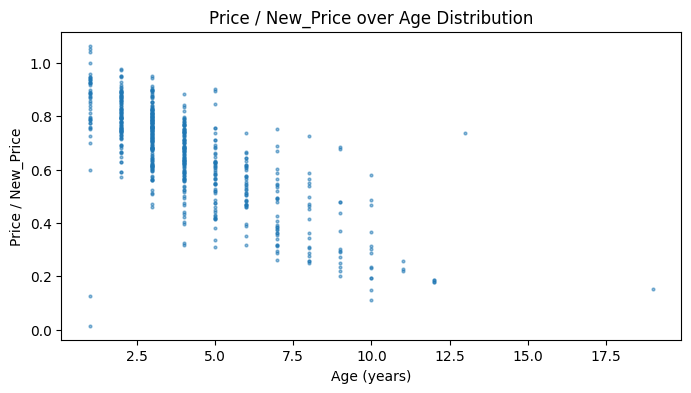

In [97]:
X_train_intersection = X_train.dropna(subset=["New_Price"])
y_train_intersection = y_train.loc[X_train_intersection.index]
current_year = 2020

ages = current_year - X_train_intersection.Year
prices_over_new_price = y_train_intersection / X_train_intersection.New_Price

plt.figure(figsize=(8, 4))
plt.scatter(ages, prices_over_new_price, s=4, alpha=0.5)


plt.xlabel("Age (years)")
plt.ylabel("Price / New_Price")
plt.title("Price / New_Price over Age Distribution")
plt.show()

#### `Model` $\times$ `Power`


In [98]:
class ModelPowerInteraction(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        model_col="Model",
        power_col="Power",
        model_power_col="Model-Power",
    ):
        self.model_col = model_col
        self.power_col = power_col
        self.model_power_col = model_power_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.model_power_col] = X[self.model_col] * X[self.power_col]
        return X


In [99]:
model_power_interaction_exp = Experiment(
    ExperimentConfig(
        name="model_power_interaction",
        pipeline=Pipeline(
            [
                *best_single_feature_pipeline.steps[:-2],
                ("model_power_interaction", ModelPowerInteraction()),
                *best_single_feature_pipeline.steps[-2:],
            ]
        ),
    )
)

model_power_interaction_exp.run(
    X_train, y_train, None, best_feature_by_feature_exp_result
);

[Experiment: model_power_interaction]
Cross-validating (5-folds)...
CV score: 0.1360 ± 0.0141
         -0.0018  -0.0032 compared to combine-all-feature-by-feature-engineering (Negative is better)
Training on full training set...
Experiment complete



In [100]:
current_best_exp = Experiment(
    ExperimentConfig(
        name="current-best",
        pipeline=Pipeline(
            [
                *best_single_feature_pipeline.steps[:-2],
                ("brand_power_interaction", BrandPowerInteraction()),
                ("model_power_interaction", ModelPowerInteraction()),
                *best_single_feature_pipeline.steps[-2:],
            ]
        ),
    )
)

current_best_exp.run(X_train, y_train, None, best_feature_by_feature_exp_result);

[Experiment: current-best]
Cross-validating (5-folds)...
CV score: 0.1372 ± 0.0116
         -0.0007  -0.0057 compared to combine-all-feature-by-feature-engineering (Negative is better)
Training on full training set...
Experiment complete



#### Ontology Approach


In [101]:
df_train.columns

Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Colour',
       'Seats', 'Doors', 'New_Price', 'Price'],
      dtype='object')

Purely data-driven approach is failing. Attempting to build a strongly domain-knowledge based ontology of features.


In [102]:
used_car_price_ontology = {
    "Car_Spec": {
        "Power": ["Engine", "Power", "Fuel_Type", "Transmission"],
        "Form": ["Seats", "Doors", "Colour"],
        "Positioning": ["Brand", "Model", "Name", "New_Price"],
    },
    "Condition": {"Wear": ["Age", "Kilometers_Driven"], "Ownership": ["Owner_Type"]},
    "Market": ["Location"],
}

The `Car_Spec` will determine the car's `BaseValue`,
the `Condition` will determine the car's `Depreciation`, and
the `Market` will determine the `MarketInfluence`.


In [103]:
class BaseValueIndexTransformer(TransformerMixin, BaseEstimator):
    def __init__(
        self,
        brand_col="Brand",
        model_col="Model",
        fuel_col="Fuel_Type",
        trans_col="Transmission",
        engine_col="Engine",
        power_col="Power",
        seats_col="Seats",
        doors_col="Doors",
        name_col="Name",
        new_price_col="New_Price",
        n_segments=3,
    ):
        self.brand_col = brand_col
        self.model_col = model_col
        self.fuel_col = fuel_col
        self.trans_col = trans_col
        self.engine_col = engine_col
        self.power_col = power_col
        self.seats_col = seats_col
        self.doors_col = doors_col
        self.name_col = name_col
        self.new_price_col = new_price_col
        self.n_segments = n_segments

    def _spec_features(self, df: pd.DataFrame) -> pd.DataFrame:
        out = pd.DataFrame(index=df.index)

        out["LogEngine"] = np.log1p(df[self.engine_col])
        out["LogPower"] = np.log1p(df[self.power_col])
        out["PowerDensity"] = df[self.power_col] / df[self.engine_col]

        out[self.seats_col] = df[self.seats_col]
        out[self.doors_col] = df[self.doors_col]

        return out

    def fit(
        self, X: pd.DataFrame, y: Optional[pd.Series] = None
    ) -> "BaseValueIndexTransformer":
        df = X.copy()

        mask = df[self.new_price_col].notna()
        df_known = df.loc[mask].copy()

        num_df = self._spec_features(df_known)

        cat_df = df_known[
            [self.brand_col, self.model_col, self.fuel_col, self.trans_col]
        ]

        self.ohe_ = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        cat_arr = self.ohe_.fit_transform(cat_df)

        num_arr = num_df.fillna(0).values
        X_spec = np.hstack([cat_arr, num_arr])

        self.kmeans_ = KMeans(n_clusters=self.n_segments, random_state=42)
        segments = self.kmeans_.fit_predict(X_spec)
        df_known["Segment"] = segments

        self.num_features_ = num_df.columns.tolist()

        X_reg = np.hstack([X_spec, segments.reshape(-1, 1)])
        y_reg = df_known[self.new_price_col]

        self.reg_ = LinearRegression()
        self.reg_.fit(X_reg, y_reg)

        self.base_mean_ = y_reg.mean()

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()

        num_df = self._spec_features(df)

        cat_df = df[[self.brand_col, self.model_col, self.fuel_col, self.trans_col]]
        cat_arr = self.ohe_.transform(cat_df)

        num_arr = num_df.fillna(0).values

        X_spec = np.hstack([cat_arr, num_arr])

        segments = self.kmeans_.predict(X_spec)
        df["Segment"] = segments

        X_reg = np.hstack([X_spec, segments.reshape(-1, 1)])

        estimated_np = self.reg_.predict(X_reg)

        df["BaseValueIndex"] = estimated_np / self.base_mean_

        return df


In [104]:
class WearIndexTransformer(TransformerMixin, BaseEstimator):
    def __init__(
        self,
        age_col="Age",
        km_col="Kilometers_Driven",
        engine_col="Engine",
        owner_col="Owner_Type",
    ):
        self.age_col = age_col
        self.km_col = km_col
        self.engine_col = engine_col
        self.owner_col = owner_col

    def _build_wear_features(self, df: pd.DataFrame) -> pd.DataFrame:
        out = pd.DataFrame(index=df.index)

        age = df[self.age_col].fillna(0)
        km = df[self.km_col].fillna(0)

        engine = df[self.engine_col].fillna(df[self.engine_col].median())

        out["Age_scaled"] = age
        out["KM_per_Year"] = km / (age + 1)
        out["WearFactor"] = km / (engine + 1)

        return out

    def fit(
        self, X: pd.DataFrame, y: Optional[pd.Series] = None
    ) -> "WearIndexTransformer":
        df = X.copy()

        wear_df = self._build_wear_features(df)

        owner_vals = df[self.owner_col].astype("category").cat.codes
        wear_df["OwnerEncoded"] = owner_vals

        self.scaler_ = StandardScaler()
        wear_scaled = self.scaler_.fit_transform(wear_df)

        self.reg_ = LinearRegression()
        self.reg_.fit(wear_scaled, np.arange(len(wear_scaled)))

        self.w_ = self.reg_.coef_

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()

        wear_df = self._build_wear_features(df)
        owner_vals = df[self.owner_col].astype("category").cat.codes
        wear_df["OwnerEncoded"] = owner_vals

        wear_scaled = self.scaler_.transform(wear_df)

        wear_score = wear_scaled @ self.w_

        wear_index = (wear_score - wear_score.min()) / (
            wear_score.max() - wear_score.min()
        )

        df["WearIndex"] = wear_index

        return df

In [105]:
class MarketIndexTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, location_col="Location"):
        self.location_col = location_col

    def fit(
        self, X: pd.DataFrame, y: Optional[pd.Series] = None
    ) -> "MarketIndexTransformer":
        df = X.copy()
        df["Price"] = y

        loc_means = df.groupby(self.location_col)["Price"].mean()

        df["LocMean"] = df[self.location_col].map(loc_means)

        self.ohe_ = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        loc_ohe = self.ohe_.fit_transform(df[[self.location_col]])

        self.reg_ = LinearRegression()
        self.reg_.fit(loc_ohe, df["LocMean"])

        self.global_mean_ = df["Price"].mean()

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()

        loc_ohe = self.ohe_.transform(df[[self.location_col]])

        loc_score = self.reg_.predict(loc_ohe)

        df["MarketIndex"] = loc_score / self.global_mean_

        return df


In [106]:
class OntologyFeatureBuilder(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        base_transformer,
        wear_transformer,
        market_transformer,
        add_interactions=True,
        add_composite=True,
    ):
        self.base_transformer = base_transformer
        self.wear_transformer = wear_transformer
        self.market_transformer = market_transformer
        self.add_interactions = add_interactions
        self.add_composite = add_composite

    def fit(self, X, y):
        self.base_transformer.fit(X)

        self.wear_transformer.fit(X)

        self.market_transformer.fit(X, y)

        return self

    def transform(self, X):
        df = X.copy()

        df = self.base_transformer.transform(df)
        df = self.wear_transformer.transform(df)
        df = self.market_transformer.transform(df)

        base = df["BaseValueIndex"]
        wear = df["WearIndex"]
        market = df["MarketIndex"]

        if self.add_interactions:
            df["Base_x_Wear"] = base * wear
            df["Base_x_Market"] = base * market
            df["Wear_x_Market"] = wear * market

        if self.add_composite:
            df["CompositeValue"] = base * wear * market

        return df


In [107]:
ontology_transformer = OntologyFeatureBuilder(
    base_transformer=BaseValueIndexTransformer(),
    wear_transformer=WearIndexTransformer(),
    market_transformer=MarketIndexTransformer(),
    add_interactions=True,
    add_composite=True,
)

In [108]:
ontology_exp = Experiment(
    ExperimentConfig(
        name="ontology-based-engineering",
        pipeline=Pipeline(
            [
                *best_single_feature_pipeline.steps[:-2],
                ("ontology", ontology_transformer),
                *best_single_feature_pipeline.steps[-2:],
            ]
        ),
    )
)

ontology_exp.run(X_train, y_train, None, best_feature_by_feature_exp_result);


[Experiment: ontology-based-engineering]
Cross-validating (5-folds)...
CV score: 0.1475 ± 0.0179
         +0.0096  +0.0005 compared to combine-all-feature-by-feature-engineering (Negative is better)
Training on full training set...
Experiment complete



---

Final Feature Engineering Pipeline


In [109]:
def final_pipeline_builder(model_config=dict()) -> Pipeline:
    return Pipeline(
        [
            ("extract_brand_model", BrandModelExtractor()),
            (
                "target_encode",
                TargetEncoder(cols=["Brand", "Model", "Name", "Location"]),
            ),
            ("transform", YearToAgeTransformer()),
            ("Kilometers_Driven_clip_outliers", KilometersDrivenClipper()),
            ("group_infrequent_fuel_type", FuelTypeGrouper()),
            ("mileage_clip_outliers", MileageClipper()),
            ("imput_power", PowerImputer()),
            ("bin_seats", SeatsBinner()),
            ("transform_new_price", NewPriceTransformer()),
            ("brand_power_interaction", BrandPowerInteraction()),
            ("model_power_interaction", ModelPowerInteraction()),
            ("category_encode", CategoricalEncoder()),
            (
                "model",
                TransformedTargetRegressor(
                    regressor=XGBRegressor(**model_config),
                    func=np.log1p,
                    inverse_func=np.expm1,
                ),
            ),
        ]
    )

In [110]:
current_best_exp = Experiment(
    ExperimentConfig(
        name="current-best",
        pipeline=final_pipeline_builder(),
    )
)

current_best_exp.run(X_train, y_train, None, best_feature_by_feature_exp_result);

[Experiment: current-best]
Cross-validating (5-folds)...
CV score: 0.1372 ± 0.0116
         -0.0007  -0.0057 compared to combine-all-feature-by-feature-engineering (Negative is better)
Training on full training set...
Experiment complete

